# Multilingual Dataset Results

## Get Results

In [1]:
import json
import matplotlib.pyplot as plt


def read_file(f):
    with open(f, "r") as f:
        return json.load(f)

In [2]:
models = {
    "xglm": [
        "xglm-564M",
        "xglm-1.7B",
        "xglm-2.9B",
        #"xglm-4.5B",
        "xglm-7.5B",
    ],
    "bloom": [
        "bloom-560m",
        #"bloom-1b1",
        "bloom-1b7",
        "bloom-3b",
        "bloom-7b1",
    ],
    "llama": [
        "llama-7B",
        "llama-13B",
        "llama-30B",
        #"llama-65B",
    ],
    "llama-2": [
        "Llama-2-7b-hf",
        "Llama-2-13b-hf",
        #"Llama-2-7b-chat-hf",
        "Llama-2-13b-chat-hf",
        #"Llama-2-70b-hf",
    ],
    "redpajama": [
        "RedPajama-INCITE-Base-3B-v1",
        "RedPajama-INCITE-7B-Base",
    ],
    "open_llama": [
        "open_llama_3b",
        "open_llama_7b",
        "open_llama_13b",
    ],
    "open_llama_v2": [
        "open_llama_3b_v2",
        "open_llama_7b_v2",
    ],
    "polylm": [
        "polylm-1.7b",
        "polylm-13b",
        "polylm-multialpaca-13b",
    ],
    "falcon": [
        "falcon-7b",
        "falcon-40b",
    ],
    "xgen": [
        "xgen-7b-4k-base",
        "xgen-7b-8k-base",
        "xgen-7b-8k-inst",
    ],
}

models_reverse = {}
for model, names in models.items():
    for name in names:
        models_reverse[name] = model
        
models_bloom_xglm = {
    "xglm": models["xglm"],
    "bloom": models["bloom"],
}

In [3]:
datasets = ["xstory_cloze", "xcopa", "xnli", "pawsx", "mgsm"] # xwinograd
datasets_mt = ["xstory_cloze-mt", "xcopa-mt", "xnli-mt", "xnli-mt-all", "pawsx-mt", "mgsm-mt"]
datasets_mt_few_shot = ["xstory_cloze-mt-few-shot", "xcopa-mt-few-shot", "xnli-mt-few-shot", "pawsx-mt-few-shot", "mgsm-mt-few-shot"]
datasets_mt_bloom = ["xstory_cloze-mt_bloom", "xcopa-mt_bloom", "xnli-mt_bloom", "pawsx-mt_bloom"] # "mgsm-mt_bloom"
datasets_mt_xglm = ["xstory_cloze-mt_xglm", "xcopa-mt_xglm", "xnli-mt_xglm", "pawsx-mt_xglm"] # "mgsm-mt_xglm"
all_datasets = datasets + datasets_mt + datasets_mt_few_shot
all_datasets_bloom_xglm = datasets + datasets_mt_bloom + datasets_mt_xglm

In [4]:
model_sizes = {
    "xglm": [0.6, 1.7, 2.9, 7.5], # 4.5
    "bloom": [0.6, 1.7, 3.0, 7.1], # 1.1
    "llama": [7.0, 13.0, 30.0], # 65.0
    "llama-2": [7.0, 13.0, 13.0], # 70.0
    "redpajama": [3.0, 7.0],
    "open_llama": [3.0, 7.0, 13.0],
    "open_llama_v2": [3.0, 7.0],
    "polylm": [1.7, 13.0, 13.0],
    "falcon": [7.0, 40.0],
    "xgen": [7.0, 7.0, 7.0],
}

# list including all models
model_sizes_all = []
for sizes in model_sizes.values():
    model_sizes_all += sizes

Mikel

xnli
- high: es, ru, zh
- low: sw, hi, ur


xstorycloze
- high: es, ru, zh
- low: sw, hi, my

xcopa
- high: it, zh, id
- low: sw, ta, ht

In [5]:
# mikel
languages = {
    "high": ["es", "ru", "zh", "it", "id"],
    "low": ["sw", "hi", "ur", "my", "ta", "ht"]
}

# xglm
languages = {
    "high": ["ru", "zh", "de", "es", "fr", "ja"],
    # "medium": ["it", "pt", "el", "ko", "fi", "id", "tr", "ar", "vi", "th", "bg", "ca"],
    "low": ["hi", "et", "bn", "ta", "ur", "sw", "te", "eu", "my", "ht", "qu"],
    # "ex_low": ["eu", "my", "ht", "qu"]
}



In [6]:
from collections import defaultdict

def get_results(results, dataset, name):
    if dataset not in datasets_mt_few_shot:
        res = {k: round(v["acc"] * 100, 1) for k, v in results.items()}
    else:
        res = {k.replace(name, "few-shot"): round(v["acc"] * 100, 1) for k, v in results.items()}
    res = dict(sorted(res.items()))
    task_names = list(res.keys())
    results_dataset = defaultdict(dict)
    dataset_names = set([task[:-3] for task in task_names])
    for dataset_name in dataset_names:
        results_dataset[dataset_name] = defaultdict(dict)
    for task in task_names:
        dataset_name = task[:-3]
        lang = task[-2:]
        results_dataset[dataset_name][lang] = res[task]
    for dataset_name, resu in results_dataset.items():
        # do not include en lang for average
        values = [v for k, v in resu.items() if k != "en"]
        results_dataset[dataset_name]["avg"] = round(sum(values) / len(values), 1)
        for resource, langs in languages.items():
            values = [v for k, v in resu.items() if k in langs]
            if len(values) > 0:
                results_dataset[dataset_name][resource] = round(sum(values) / len(values), 1)
    return results_dataset

In [7]:
from collections import defaultdict
import os

def get_all_results(models, datasets):
    all_results = defaultdict(dict)
    for model, names in models.items():
        for dataset in datasets:
            for name in names:
                shots = 8 if "mgsm" in dataset else 0
                # check if file exists
                if not os.path.exists(f"../results/{model}/{name}/{name}_{dataset}_{shots}-shot.json"):
                    print(f"../results/{model}/{name}/{name}_{dataset}_{shots}-shot.json")
                    continue
                output = read_file(
                    f"../results/{model}/{name}/{name}_{dataset}_{shots}-shot.json"
                )
                results = get_results(output["results"], dataset, name)
                for dataset_name in results:
                    if dataset_name not in all_results:
                        all_results[dataset_name] = defaultdict(dict)
                    all_results[dataset_name][name].update(results[dataset_name])
    return all_results

all_results = get_all_results(models, all_datasets)

../results/falcon/falcon-40b/falcon-40b_mgsm_8-shot.json
../results/falcon/falcon-7b/falcon-7b_xstory_cloze-mt-few-shot_0-shot.json
../results/falcon/falcon-40b/falcon-40b_xstory_cloze-mt-few-shot_0-shot.json
../results/falcon/falcon-7b/falcon-7b_xcopa-mt-few-shot_0-shot.json
../results/falcon/falcon-40b/falcon-40b_xcopa-mt-few-shot_0-shot.json
../results/falcon/falcon-7b/falcon-7b_xnli-mt-few-shot_0-shot.json
../results/falcon/falcon-40b/falcon-40b_xnli-mt-few-shot_0-shot.json
../results/falcon/falcon-7b/falcon-7b_pawsx-mt-few-shot_0-shot.json
../results/falcon/falcon-40b/falcon-40b_pawsx-mt-few-shot_0-shot.json
../results/falcon/falcon-7b/falcon-7b_mgsm-mt-few-shot_8-shot.json
../results/falcon/falcon-40b/falcon-40b_mgsm-mt-few-shot_8-shot.json
../results/xgen/xgen-7b-4k-base/xgen-7b-4k-base_xstory_cloze-mt-few-shot_0-shot.json
../results/xgen/xgen-7b-8k-base/xgen-7b-8k-base_xstory_cloze-mt-few-shot_0-shot.json
../results/xgen/xgen-7b-8k-inst/xgen-7b-8k-inst_xstory_cloze-mt-few-shot_

In [8]:
all_results_bloom_xglm = get_all_results(models_bloom_xglm, all_datasets_bloom_xglm)

../results/xglm/xglm-564M/xglm-564M_xnli-mt_bloom_0-shot.json
../results/xglm/xglm-1.7B/xglm-1.7B_xnli-mt_bloom_0-shot.json
../results/xglm/xglm-2.9B/xglm-2.9B_xnli-mt_bloom_0-shot.json
../results/xglm/xglm-7.5B/xglm-7.5B_xnli-mt_bloom_0-shot.json


../results/bloom/bloom-560m/bloom-560m_xnli-mt_bloom_0-shot.json
../results/bloom/bloom-1b7/bloom-1b7_xnli-mt_bloom_0-shot.json
../results/bloom/bloom-3b/bloom-3b_xnli-mt_bloom_0-shot.json
../results/bloom/bloom-7b1/bloom-7b1_xnli-mt_bloom_0-shot.json


In [9]:
all_results_bloom_xglm.keys()

dict_keys(['xstory_cloze', 'xcopa', 'xnli', 'pawsx', 'mgsm', 'xstory_cloze-mt_bloom-7b1', 'xstory_cloze-mt_bloom-1b7', 'xstory_cloze-mt_bloom-560m', 'xstory_cloze-mt_bloom-3b', 'xcopa-mt_bloom-7b1', 'xcopa-mt_bloom-1b7', 'xcopa-mt_bloom-560m', 'xcopa-mt_bloom-3b', 'pawsx-mt_bloom-1b7', 'pawsx-mt_bloom-3b', 'pawsx-mt_bloom-560m', 'pawsx-mt_bloom-7b1', 'xstory_cloze-mt_xglm-2.9B', 'xstory_cloze-mt_xglm-7.5B', 'xstory_cloze-mt_xglm-564M', 'xstory_cloze-mt_xglm-1.7B', 'xcopa-mt_xglm-564M', 'xcopa-mt_xglm-7.5B', 'xcopa-mt_xglm-1.7B', 'xcopa-mt_xglm-2.9B', 'xnli-mt_xglm-1.7B', 'xnli-mt_xglm-7.5B', 'xnli-mt_xglm-564M', 'xnli-mt_xglm-2.9B', 'pawsx-mt_xglm-564M', 'pawsx-mt_xglm-2.9B', 'pawsx-mt_xglm-1.7B', 'pawsx-mt_xglm-7.5B'])

In [10]:
all_results.keys()

dict_keys(['xstory_cloze', 'xcopa', 'xnli', 'pawsx', 'mgsm', 'xstory_cloze-mt_nllb-200-distilled-1.3B', 'xstory_cloze-mt_nllb-200-distilled-600M', 'xstory_cloze-mt_nllb-200-1.3B', 'xstory_cloze-mt_nllb-200-3.3B', 'xcopa-mt_nllb-200-3.3B', 'xcopa-mt_nllb-200-distilled-600M', 'xcopa-mt_nllb-200-distilled-1.3B', 'xcopa-mt_nllb-200-1.3B', 'xnli-mt_nllb-200-3.3B', 'xnli-mt_nllb-200-distilled-600M', 'xnli-mt_nllb-200-1.3B', 'xnli-mt_nllb-200-distilled-1.3B', 'pawsx-mt_nllb-200-distilled-1.3B', 'pawsx-mt_nllb-200-1.3B', 'pawsx-mt_nllb-200-distilled-600M', 'pawsx-mt_nllb-200-3.3B', 'mgsm-mt_nllb-200-1.3B', 'mgsm-mt_nllb-200-distilled-1.3B', 'mgsm-mt_nllb-200-3.3B', 'mgsm-mt_nllb-200-distilled-600M', 'xstory_cloze-mt_few-shot', 'xcopa-mt_few-shot', 'xnli-mt_few-shot', 'pawsx-mt_few-shot', 'mgsm-mt_few-shot', 'pawsx-mt_xgen-7b-8k-base'])

## Results by Dataset

In [11]:
import pandas as pd

def get_dataframes(all_results, datasets):
    results_avg = pd.DataFrame()
    for dataset in datasets:
        results = pd.DataFrame(all_results[dataset]).T
        results["dataset"] = dataset
        results["model"] = [models_reverse[model] for model in results.index]
        results["size"] = model_sizes_all[:len(results)]
        results_avg["model"] = results["model"]
        results_avg["size"] = results["size"]
        results_avg[dataset] = results["avg"]
        yield results
    # skip size column for avg
    size = results_avg["size"]
    results_avg = results_avg.drop(columns=["size"])
    results_avg["avg"] = results_avg.mean(axis=1).round(1)
    results_avg["dataset"] = "avg"
    results_avg["size"] = size
    yield results_avg
    

In [12]:
def plot_size_df_models(df, langs=False):
    df.set_index("size", inplace=True)
    df.groupby("model")["avg"].plot(
        x="size", y="acc", title=list(df["dataset"])[0], legend=True, marker="o"
    )
    # x axis in log scale
    plt.xscale("log")
    plt.xticks(model_sizes_all, model_sizes_all, rotation="vertical");
    plt.show()
    # iterate all langs
    if langs:
        for lang in df.columns:
            if lang in ["dataset", "model", "avg", "size"]:
                continue
            df.groupby("model")[lang].plot(x="size", title=f"{list(df['dataset'])[0]}_{lang}", legend=True, marker="o")
            plt.xscale("log")
            plt.xticks(model_sizes_all, model_sizes_all, rotation="vertical");
            plt.show()

In [13]:
datasets_all = list(all_results.keys())
dfs_mt = get_dataframes(all_results, datasets)


,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,high,low,dataset,model,size
xglm-564M,50.1,60.6,55.1,53.1,52.3,54.0,51.5,56.2,53.1,55.9,53.3,53.5,54.9,53.2,xstory_cloze,xglm,0.6
xglm-1.7B,52.5,64.3,59.2,56.1,55.8,58.0,53.8,59.8,56.0,58.0,56.2,56.5,58.4,55.9,xstory_cloze,xglm,1.7
xglm-2.9B,53.9,67.3,61.0,56.3,57.5,61.4,55.2,62.2,56.7,60.0,57.6,58.2,60.3,57.1,xstory_cloze,xglm,2.9
xglm-7.5B,56.2,69.8,64.1,57.7,58.8,62.9,57.1,63.5,59.3,60.2,58.9,59.9,62.2,58.6,xstory_cloze,xglm,7.5
bloom-560m,52.1,61.2,55.9,53.6,55.0,55.5,47.2,49.2,49.8,55.7,54.5,52.9,53.2,52.3,xstory_cloze,bloom,0.6
bloom-1b7,55.0,64.7,60.8,54.9,56.8,59.8,47.3,50.4,52.3,56.5,58.2,55.2,56.5,53.6,xstory_cloze,bloom,1.7
bloom-3b,56.6,66.8,64.1,55.7,57.6,60.8,46.6,50.7,53.0,58.2,60.9,56.4,58.6,54.2,xstory_cloze,bloom,3.0
bloom-7b1,58.6,70.7,66.1,57.2,60.6,64.5,49.0,52.7,53.9,57.4,61.9,58.2,60.2,55.6,xstory_cloze,bloom,7.1
llama-7B,48.3,74.8,65.1,50.1,52.7,52.1,48.7,61.4,50.4,52.9,54.3,53.6,60.3,51.0,xstory_cloze,llama,7.0
llama-13B,49.7,77.3,69.4,50.7,52.3,55.3,47.8,63.4,49.9,53.3,56.5,54.8,63.1,50.8,xstory_cloze,llama,13.0


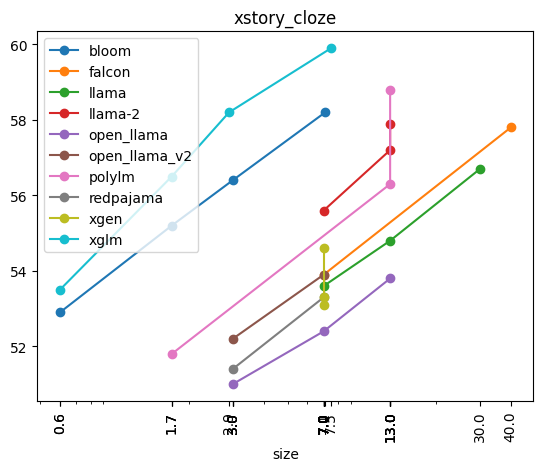

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,high,low,dataset,model,size
xglm-564M,55.6,55.0,57.2,53.8,49.2,53.2,56.2,55.2,54.4,58.4,55.6,54.9,55.6,53.8,xcopa,xglm,0.6
xglm-1.7B,56.8,55.8,64.6,54.0,52.2,56.6,55.2,58.2,53.4,63.0,58.0,57.1,58.0,55.3,xcopa,xglm,1.7
xglm-2.9B,58.2,55.8,66.8,60.2,50.2,58.8,54.2,57.0,56.6,65.2,60.0,58.5,60.0,55.4,xcopa,xglm,2.9
xglm-7.5B,61.2,57.4,69.4,63.6,48.8,60.0,54.4,59.4,58.4,70.2,63.8,60.6,63.8,56.4,xcopa,xglm,7.5
bloom-560m,49.0,50.2,59.2,50.8,50.2,51.6,55.8,54.4,53.0,61.0,58.6,54.0,58.6,51.4,xcopa,bloom,0.6
bloom-1b7,47.4,50.4,63.2,52.6,50.6,51.8,56.6,53.2,52.8,65.8,61.4,55.1,61.4,51.4,xcopa,bloom,1.7
bloom-3b,49.2,50.2,69.2,51.6,50.6,51.4,58.0,52.6,53.4,68.8,62.0,56.1,62.0,51.9,xcopa,bloom,3.0
bloom-7b1,48.2,50.8,69.8,52.8,50.8,51.6,59.2,55.4,51.2,70.8,65.2,56.9,65.2,52.1,xcopa,bloom,7.1
llama-7B,48.8,51.0,54.6,62.0,51.4,50.8,55.2,55.8,55.6,51.6,56.2,53.9,56.2,51.4,xcopa,llama,7.0
llama-13B,48.2,52.8,57.8,67.2,50.2,51.2,54.4,54.6,53.0,53.8,58.4,54.7,58.4,51.4,xcopa,llama,13.0


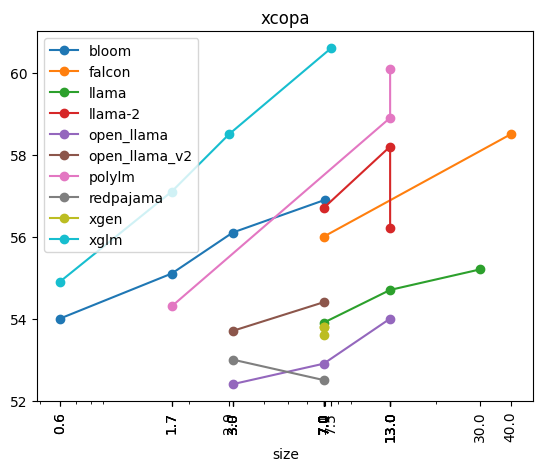

,ar,bg,de,el,en,es,fr,hi,ru,sw,...,tr,ur,vi,zh,avg,high,low,dataset,model,size
xglm-564M,33.4,41.3,44.5,39.6,48.3,42.0,45.5,38.7,44.6,36.1,...,40.2,34.5,38.5,33.5,39.4,42.0,36.4,xnli,xglm,0.6
xglm-1.7B,33.5,44.7,45.3,40.1,49.7,43.6,45.7,42.6,46.0,42.0,...,43.0,39.5,45.0,33.8,41.9,42.9,41.4,xnli,xglm,1.7
xglm-2.9B,33.7,46.0,48.3,41.4,51.1,46.7,45.0,44.0,45.3,44.4,...,45.0,40.1,46.0,34.8,43.0,44.0,42.8,xnli,xglm,2.9
xglm-7.5B,33.4,44.9,49.0,40.7,53.9,47.7,46.9,47.2,46.3,45.8,...,46.3,42.1,46.3,35.4,44.0,45.1,45.0,xnli,xglm,7.5
bloom-560m,33.4,33.4,34.8,33.3,49.5,45.2,45.3,40.8,34.0,33.2,...,33.4,37.1,40.5,34.0,36.6,38.7,37.0,xnli,bloom,0.6
bloom-1b7,33.6,35.4,40.6,34.0,50.1,47.8,48.2,44.0,39.3,34.5,...,34.9,40.5,46.2,36.2,39.2,42.4,39.7,xnli,bloom,1.7
bloom-3b,33.4,37.9,40.4,33.2,53.4,49.1,49.2,45.5,41.4,35.8,...,33.8,40.0,46.5,37.4,39.8,43.5,40.4,xnli,bloom,3.0
bloom-7b1,33.8,39.7,39.9,35.7,53.9,48.7,49.7,46.5,43.1,37.9,...,35.1,42.1,47.0,35.4,40.7,43.4,42.2,xnli,bloom,7.1
llama-7B,33.6,37.0,44.8,34.9,51.1,40.6,43.8,36.1,39.4,33.7,...,35.6,33.4,35.6,36.2,37.1,41.0,34.4,xnli,llama,7.0
llama-13B,34.1,34.2,35.2,34.7,35.6,33.5,33.5,35.6,33.8,33.2,...,34.0,34.2,34.2,34.5,34.2,34.1,34.3,xnli,llama,13.0


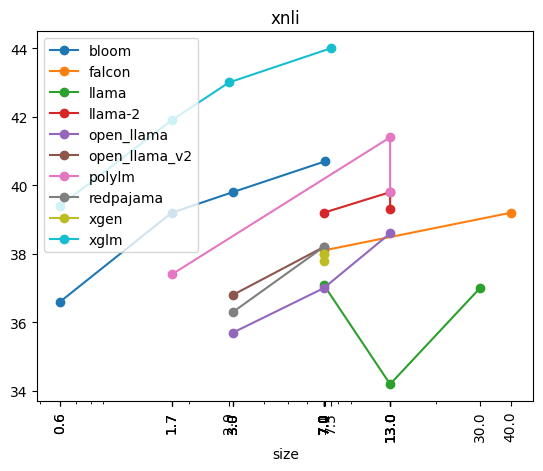

,de,en,es,fr,ja,ko,zh,avg,high,dataset,model,size
xglm-564M,49.1,50.6,52.5,50.8,44.1,46.2,47.8,48.4,48.9,pawsx,xglm,0.6
xglm-1.7B,57.6,52.6,53.8,47.3,46.1,51.4,48.1,50.7,50.6,pawsx,xglm,1.7
xglm-2.9B,50.6,54.8,53.1,49.7,50.9,46.8,53.7,50.8,51.6,pawsx,xglm,2.9
xglm-7.5B,55.9,58.9,52.8,51.8,52.0,46.0,51.3,51.6,52.8,pawsx,xglm,7.5
bloom-560m,52.8,52.0,53.2,47.9,44.9,51.9,45.2,49.3,48.8,pawsx,bloom,0.6
bloom-1b7,48.8,48.9,51.3,46.2,44.7,45.8,45.4,47.0,47.3,pawsx,bloom,1.7
bloom-3b,54.6,56.8,56.4,47.6,44.6,46.3,47.1,49.4,50.1,pawsx,bloom,3.0
bloom-7b1,52.8,61.3,59.4,50.9,45.5,45.1,47.3,50.2,51.2,pawsx,bloom,7.1
llama-7B,54.6,61.9,56.1,52.9,56.7,49.7,49.1,53.2,53.9,pawsx,llama,7.0
llama-13B,52.9,53.7,52.1,54.5,45.0,47.0,45.2,49.4,49.9,pawsx,llama,13.0


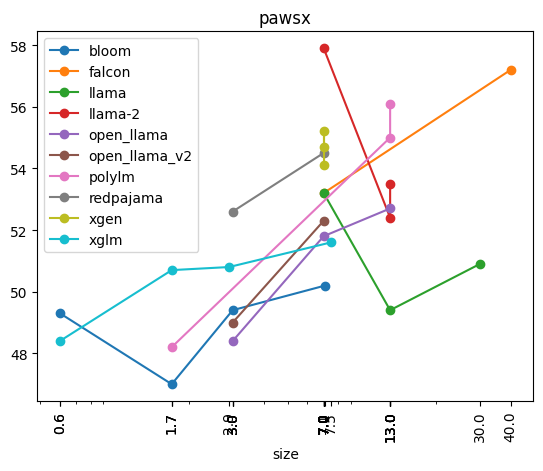

,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,high,low,dataset,model,size
xglm-564M,1.2,0.8,2.0,1.2,1.6,4.0,0.4,2.4,0.4,1.6,3.2,1.7,1.9,1.3,mgsm,xglm,0.6
xglm-1.7B,0.8,1.2,2.0,2.4,2.0,1.6,0.8,1.2,2.0,2.0,2.8,1.7,1.8,1.3,mgsm,xglm,1.7
xglm-2.9B,0.0,0.8,2.4,2.0,1.2,2.0,2.0,2.0,2.0,0.8,1.2,1.4,1.5,1.3,mgsm,xglm,2.9
xglm-7.5B,0.0,1.2,0.0,0.0,0.0,0.4,2.4,0.4,1.2,1.6,1.2,0.8,0.9,0.5,mgsm,xglm,7.5
bloom-560m,3.2,1.2,2.8,2.8,1.6,1.2,2.0,0.8,2.4,0.0,2.0,1.7,1.8,2.1,mgsm,bloom,0.6
bloom-1b7,2.0,4.0,1.2,2.4,3.2,2.8,2.4,1.6,1.6,0.0,2.8,2.3,2.9,1.7,mgsm,bloom,1.7
bloom-3b,2.0,1.2,3.2,2.8,2.0,2.4,0.8,2.8,2.4,0.0,3.2,2.0,2.1,2.4,mgsm,bloom,3.0
bloom-7b1,4.8,0.4,5.2,5.2,4.0,1.2,4.0,2.8,4.4,0.0,4.8,3.2,3.3,4.0,mgsm,bloom,7.1
llama-7B,0.0,9.6,13.6,10.4,8.8,5.2,10.0,2.0,0.0,0.0,4.4,5.0,8.1,0.7,mgsm,llama,7.0
llama-13B,0.0,16.0,20.8,15.2,15.6,5.2,10.0,3.6,0.0,0.0,8.8,7.4,11.8,1.2,mgsm,llama,13.0


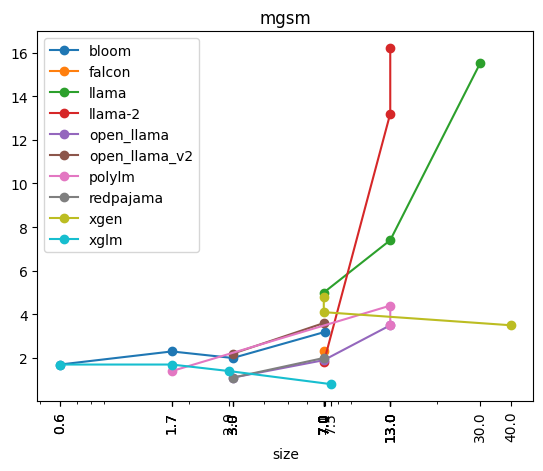

/tmp/ipykernel_962677/1123600188.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_avg["avg"] = results_avg.mean(axis=1).round(1)


,model,xstory_cloze,xcopa,xnli,pawsx,mgsm,avg,dataset,size
xglm-564M,xglm,53.5,54.9,39.4,48.4,1.7,39.6,avg,0.6
xglm-1.7B,xglm,56.5,57.1,41.9,50.7,1.7,41.6,avg,1.7
xglm-2.9B,xglm,58.2,58.5,43.0,50.8,1.4,42.4,avg,2.9
xglm-7.5B,xglm,59.9,60.6,44.0,51.6,0.8,43.4,avg,7.5
bloom-560m,bloom,52.9,54.0,36.6,49.3,1.7,38.9,avg,0.6
bloom-1b7,bloom,55.2,55.1,39.2,47.0,2.3,39.8,avg,1.7
bloom-3b,bloom,56.4,56.1,39.8,49.4,2.0,40.7,avg,3.0
bloom-7b1,bloom,58.2,56.9,40.7,50.2,3.2,41.8,avg,7.1
llama-7B,llama,53.6,53.9,37.1,53.2,5.0,40.6,avg,7.0
llama-13B,llama,54.8,54.7,34.2,49.4,7.4,40.1,avg,13.0


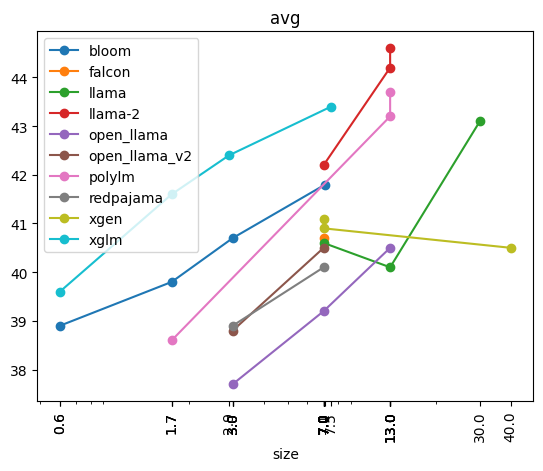

In [14]:
for df in dfs_mt:
    display(df)
    plot_size_df_models(df)

## Results by Model

In [15]:
def get_dataframes_model(all_results, datasets, model_name, divide=False):
    dataset_keys = list(all_results.keys())
    if divide:
        df_avg_self = pd.DataFrame()
        df_avg_mt = pd.DataFrame()
    else:
        df_avg = {}
        for average in ["avg"] + list(languages.keys()):
            df_avg[average] = pd.DataFrame()
    for dataset in datasets:
        dfs = []
        for dataset_key in dataset_keys:
            if dataset_key.startswith(dataset):
                # skip if dataset key contains a different model
                if model_name == "open_llama_v2":
                    if not any([model.lower() in models["open_llama_v2"] for model in all_results[dataset_key]]):
                        continue
                elif not any([model_name in model.lower() for model in all_results[dataset_key]]):
                    continue
                # skip if small nllb model
                if "600M" in dataset_key or "1.3B" in dataset_key:
                    continue
                results = pd.DataFrame(all_results[dataset_key]).T
                results["dataset"] = dataset_key
                results["model"] = [models_reverse[model] for model in results.index]
                results = results[results["model"] == model_name]
                results.drop(columns=["model"], inplace=True)
                results["model"] = model_name
                results["size"] = model_sizes[model_name][:len(results)]
                dfs.append(results)
        df_concat = pd.concat(dfs)
        df_concat = df_concat.sort_values(["size", "dataset"])
        df_concat = df_concat.reindex(columns=["model", "size", "dataset"] + [col for col in df_concat.columns if col not in ["model", "size", "dataset"]])
        df_concat["dataset"] = df_concat["dataset"].str.replace(dataset, "Direct")
        df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_few-shot", "Self-translate")
        df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
        # divide into 2 dataframes, one for Direct and Self-MT, one for Self-MT and MT
        if divide:
            df_concat_self = df_concat[df_concat["dataset"].isin(["Direct", "Self-MT"])]
            df_concat_mt = df_concat[df_concat["dataset"].isin(["Self-MT", "MT"])]
            df_avg_self["model"] = df_concat_self["model"]
            df_avg_self["size"] = df_concat_self["size"]
            df_avg_self["dataset"] = df_concat_self["dataset"]
            df_avg_self[dataset] = df_concat_self["avg"]
            # repeat for mt 
            df_avg_mt["model"] = df_concat_mt["model"]
            df_avg_mt["size"] = df_concat_mt["size"]
            df_avg_mt["dataset"] = df_concat_mt["dataset"]
            df_avg_mt[dataset] = df_concat_mt["avg"]     
            yield df_concat_self
            yield df_concat_mt
        else:
            for average in ["avg"] + list(languages.keys()):
                df_avg[average]["model"] = df_concat["model"]
                df_avg[average]["size"] = df_concat["size"]
                df_avg[average]["dataset"] = df_concat["dataset"]
                df_avg[average][dataset] = df_concat[average]
            yield df_concat
    # add an avg column
    if divide:
        size = df_avg_self["size"]
        df_avg_self = df_avg_self.drop(columns=["size"])
        size = df_avg_mt["size"]
        df_avg_mt = df_avg_mt.drop(columns=["size"])
        df_avg_self["avg"] = df_avg_self.mean(axis=1).round(1)
        df_avg_mt["avg"] = df_avg_mt.mean(axis=1).round(1)
        df_avg_self["size"] = size
        df_avg_mt["size"] = size
        yield df_avg_self
        yield df_avg_mt
    else:
        for average in ["avg"] + list(languages.keys()):
            size = df_avg[average]["size"]
            df_avg[average] = df_avg[average].drop(columns=["size"])
            df_avg[average][average] = df_avg[average].mean(axis=1).round(1)
            df_avg[average]["size"] = size
            yield df_avg[average]

In [18]:
def plot_size_df_datasets(df, model_name, title, langs=False):
    titles = {
        "low": "Low-resource languages",
        "high": "High-resource languages",
        "avg": "Average",
    }
    df.set_index("size", inplace=True)
    for average in ["avg"] + list(languages.keys()):
        if average not in df.columns:
            continue
        df.groupby("dataset")[average].plot(
            x="size", y="acc", title=f"{title} {titles[average]}", ylabel="Average accuracy", xlabel="Model size (B)", legend=True, marker="o"
        )
        plt.xscale("log")
        plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
        if title == "":
            plt.ylim(46, 62)
            plt.savefig(f"plots/{model_name}_{average}.pdf", bbox_inches='tight')
        plt.show()
    # iterate all langs
    if langs:
        for lang in df.columns:
            if lang in ["dataset", "avg", "size"]:
                continue
            df.groupby("dataset")[lang].plot(x="size", y="acc", title=f"{title}_{lang}", ylabel="Accuracy", xlabel="Model size (B)", legend=True, marker="o")
            plt.xscale("log")
            plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
            plt.show()

## XGLM High/low resource

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 &         Direct & 50.1 & 60.6 & 55.1 & 53.1 & 52.3 & 54.0 & 51.5 & 56.2 & 53.1 & 55.9 & 53.3 & 53.5 &  54.9 & 53.2 \\
 xglm &   0.6 & Self-translate & 52.2 &    \_ & 53.1 & 54.0 & 53.5 & 53.6 & 52.3 & 53.9 & 52.1 & 53.0 & 50.0 & 52.8 &  52.3 & 53.0 \\
 xglm &   0.6 &      MT (NLLB) & 58.1 &    \_ & 57.2 & 55.7 & 57.4 & 57.9 & 55.2 & 58.8 & 56.5 & 59.5 & 56.8 & 57.3 &  57.6 & 56.9 \\
 xglm &   1.7 &         Direct & 52.5 & 64.3 & 59.2 & 56.1 & 55.8 & 58.0 & 53.8 & 59.8 & 56.0 & 58.0 & 56.2 & 56.5 &  58.4 & 55.9 \\
 xglm &   1.7 & Self-translate & 55.4 &    \_ & 58.4 & 54.3 & 55.1 & 57.1 & 55.5 & 58.4 & 55.3 & 54.8 & 54.9 & 55.9 &  57.2 & 55.0 \\
 xglm &   1.7 &      MT (NLLB) & 61.9 &    \_ & 60.4 & 58.3 & 61.7 & 61.4 & 57.8 & 62.7 & 60.0 & 61.3 & 61.6 & 60.7 &  61.6 & 59.8 \\
 xglm &   2.

/tmp/ipykernel_962677/1302956342.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_962677/4089458629.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


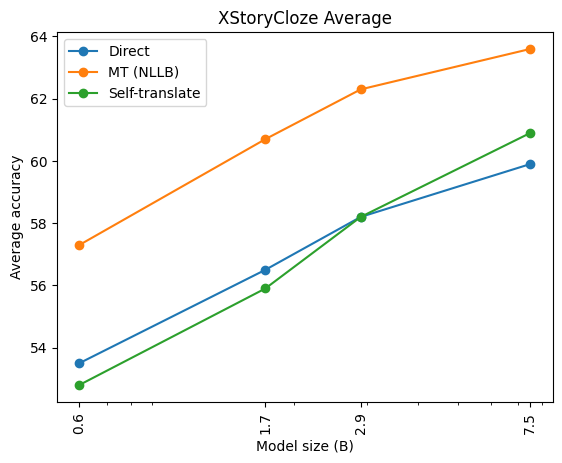

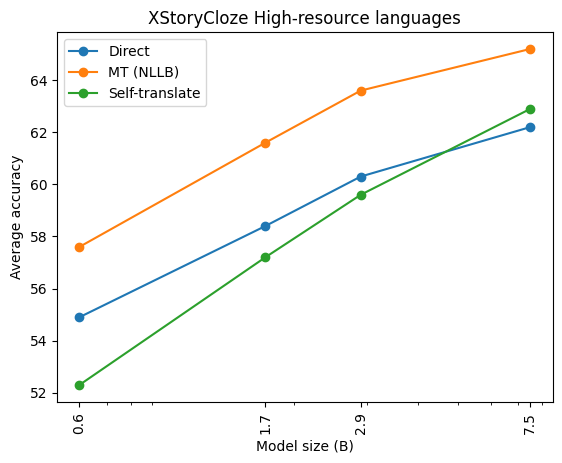

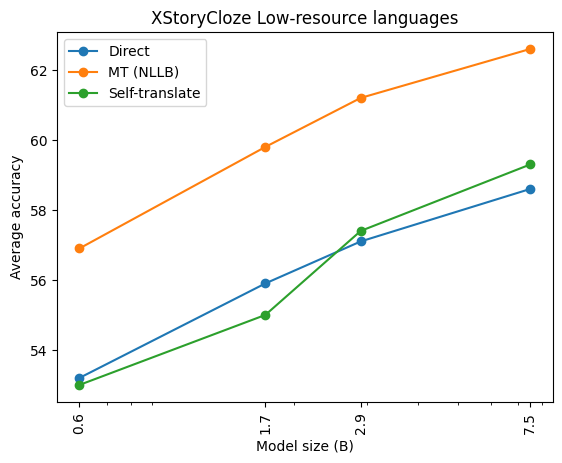

/tmp/ipykernel_962677/1302956342.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_962677/4089458629.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 &         Direct & 55.6 & 55.0 & 57.2 & 53.8 & 49.2 & 53.2 & 56.2 & 55.2 & 54.4 & 58.4 & 55.6 & 54.9 &  55.6 & 53.8 \\
 xglm &   0.6 & Self-translate & 52.2 & 54.2 & 59.4 & 51.8 & 50.0 & 52.6 & 55.0 & 55.2 & 55.2 & 51.8 & 50.4 & 53.4 &  50.4 & 52.8 \\
 xglm &   0.6 &      MT (NLLB) & 60.0 & 61.0 & 60.4 & 61.8 & 50.4 & 59.4 & 61.6 & 58.8 & 62.4 & 61.8 & 60.2 & 59.8 &  60.2 & 58.5 \\
 xglm &   1.7 &         Direct & 56.8 & 55.8 & 64.6 & 54.0 & 52.2 & 56.6 & 55.2 & 58.2 & 53.4 & 63.0 & 58.0 & 57.1 &  58.0 & 55.3 \\
 xglm &   1.7 & Self-translate & 59.0 & 57.0 & 60.6 & 60.0 & 50.8 & 57.8 & 58.8 & 58.4 & 60.8 & 61.0 & 58.4 & 58.4 &  58.4 & 56.7 \\
 xglm &   1.7 &      MT (NLLB) & 65.6 & 62.8 & 63.4 & 65.6 & 50.4 & 62.2 & 63.8 & 61.0 & 63.8 & 64.0 & 62.6 & 62.3 &  62.6 & 61.0 \\
 xglm &   2.9 & 

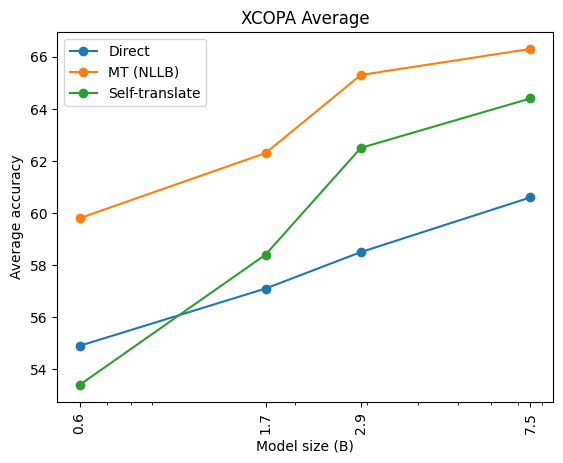

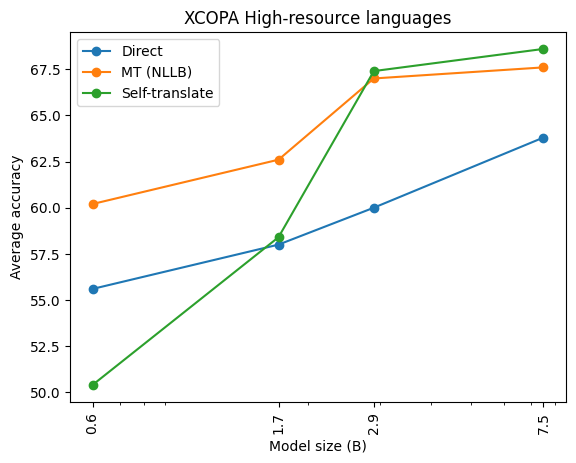

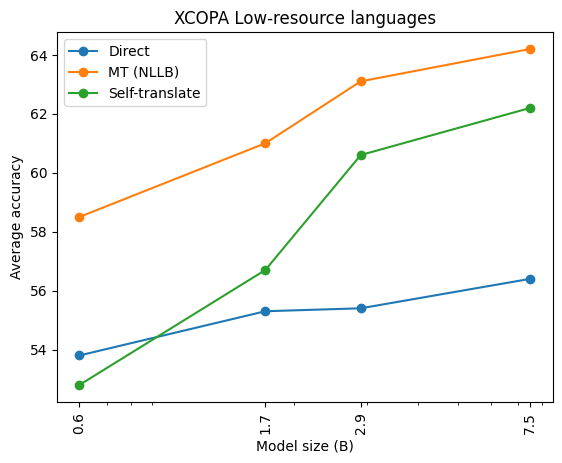

/tmp/ipykernel_962677/1302956342.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_962677/4089458629.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 &         Direct & 33.4 & 41.3 & 44.5 & 39.6 & 48.3 & 42.0 & 45.5 & 38.7 & 44.6 & 36.1 & 38.8 & 40.2 & 34.5 & 38.5 & 33.5 & 39.4 &  42.0 & 36.4 \\
 xglm &   0.6 & Self-translate & 40.2 & 43.9 & 43.9 & 42.2 &    \_ & 43.3 & 43.3 & 41.4 & 43.0 & 39.0 & 41.9 & 40.6 & 40.6 & 41.5 & 35.8 & 41.5 &  41.9 & 40.3 \\
 xglm &   0.6 &      MT (NLLB) & 46.9 & 47.1 & 46.6 & 46.6 &    \_ & 47.5 & 46.5 & 45.6 & 45.7 & 45.6 & 46.3 & 46.4 & 43.8 & 46.8 & 47.1 & 46.3 &  46.7 & 45.0 \\
 xglm &   1.7 &         Direct & 33.5 & 44.7 & 45.3 & 40.1 & 49.7 & 43.6 & 45.7 & 42.6 & 46.0 & 42.0 & 41.7 & 43.0 & 39.5 & 45.0 & 33.8 & 41.9 &  42.9 & 41.4 \\
 xglm &   1.7 & Self-translate & 44.2 & 46.8 & 47.0 & 46.1 &    \_ & 45.9 & 46.8 & 44.1 & 45.7 & 43.8 & 44.0 & 42.7 & 42.0 & 44.7 & 44.3

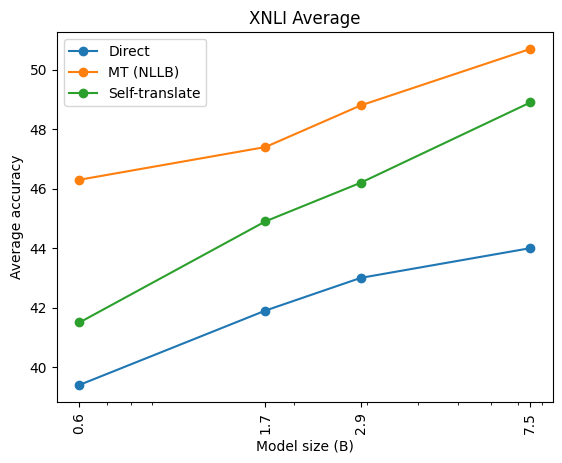

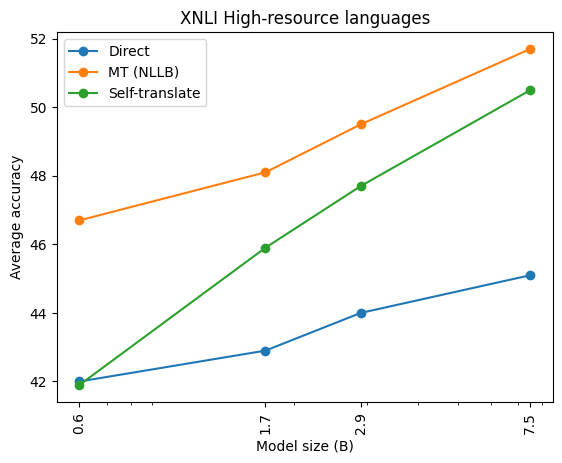

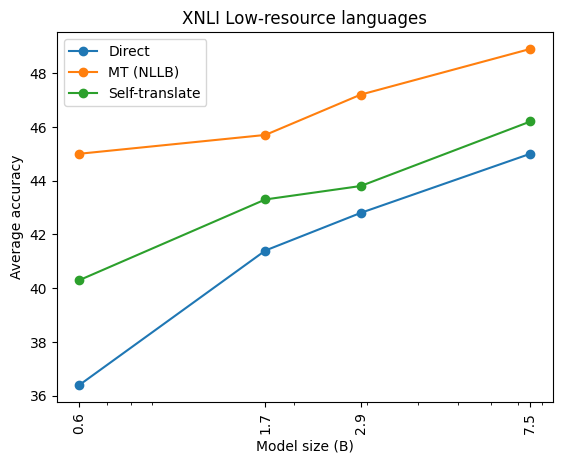

/tmp/ipykernel_962677/1302956342.py:75: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg[average][average] = df_avg[average].mean(axis=1).round(1)
/tmp/ipykernel_962677/4089458629.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{llrrrrr}
\toprule
model &        dataset &  xstory\_cloze &  xcopa &  xnli &  avg &  size \\
\midrule
 xglm &         Direct &          53.5 &   54.9 &  39.4 & 49.3 &   0.6 \\
 xglm & Self-translate &          52.8 &   53.4 &  41.5 & 49.2 &   0.6 \\
 xglm &      MT (NLLB) &          57.3 &   59.8 &  46.3 & 54.5 &   0.6 \\
 xglm &         Direct &          56.5 &   57.1 &  41.9 & 51.8 &   1.7 \\
 xglm & Self-translate &          55.9 &   58.4 &  44.9 & 53.1 &   1.7 \\
 xglm &      MT (NLLB) &          60.7 &   62.3 &  47.4 & 56.8 &   1.7 \\
 xglm &         Direct &          58.2 &   58.5 &  43.0 & 53.2 &   2.9 \\
 xglm & Self-translate &          58.2 &   62.5 &  46.2 & 55.6 &   2.9 \\
 xglm &      MT (NLLB) &          62.3 &   65.3 &  48.8 & 58.8 &   2.9 \\
 xglm &         Direct &          59.9 &   60.6 &  44.0 & 54.8 &   7.5 \\
 xglm & Self-translate &          60.9 &   64.4 &  48.9 & 58.1 &   7.5 \\
 xglm &      MT (NLLB) &          63.6 &   66.3 &  50.7 & 60.2 &   7

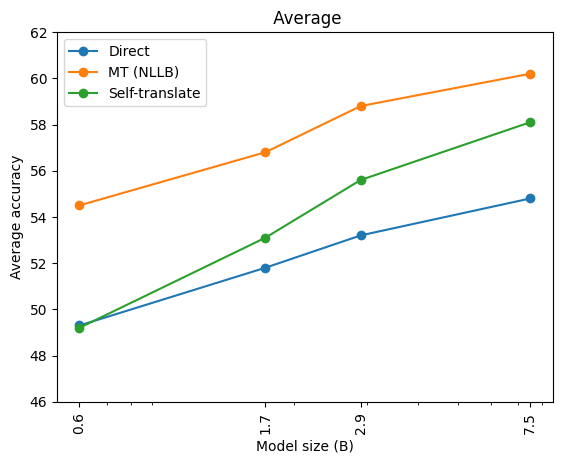

/tmp/ipykernel_962677/1302956342.py:75: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg[average][average] = df_avg[average].mean(axis=1).round(1)
/tmp/ipykernel_962677/4089458629.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{llrrrrr}
\toprule
model &        dataset &  xstory\_cloze &  xcopa &  xnli &  high &  size \\
\midrule
 xglm &         Direct &          54.9 &   55.6 &  42.0 &  50.8 &   0.6 \\
 xglm & Self-translate &          52.3 &   50.4 &  41.9 &  48.2 &   0.6 \\
 xglm &      MT (NLLB) &          57.6 &   60.2 &  46.7 &  54.8 &   0.6 \\
 xglm &         Direct &          58.4 &   58.0 &  42.9 &  53.1 &   1.7 \\
 xglm & Self-translate &          57.2 &   58.4 &  45.9 &  53.8 &   1.7 \\
 xglm &      MT (NLLB) &          61.6 &   62.6 &  48.1 &  57.4 &   1.7 \\
 xglm &         Direct &          60.3 &   60.0 &  44.0 &  54.8 &   2.9 \\
 xglm & Self-translate &          59.6 &   67.4 &  47.7 &  58.2 &   2.9 \\
 xglm &      MT (NLLB) &          63.6 &   67.0 &  49.5 &  60.0 &   2.9 \\
 xglm &         Direct &          62.2 &   63.8 &  45.1 &  57.0 &   7.5 \\
 xglm & Self-translate &          62.9 &   68.6 &  50.5 &  60.7 &   7.5 \\
 xglm &      MT (NLLB) &          65.2 &   67.6 &  51.7 

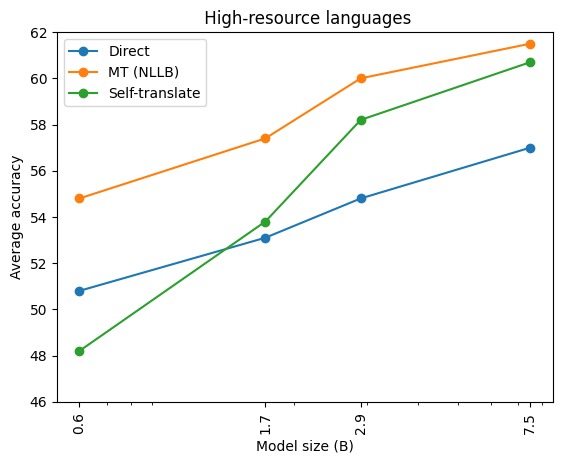

/tmp/ipykernel_962677/1302956342.py:75: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg[average][average] = df_avg[average].mean(axis=1).round(1)
/tmp/ipykernel_962677/4089458629.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{llrrrrr}
\toprule
model &        dataset &  xstory\_cloze &  xcopa &  xnli &  low &  size \\
\midrule
 xglm &         Direct &          53.2 &   53.8 &  36.4 & 47.8 &   0.6 \\
 xglm & Self-translate &          53.0 &   52.8 &  40.3 & 48.7 &   0.6 \\
 xglm &      MT (NLLB) &          56.9 &   58.5 &  45.0 & 53.5 &   0.6 \\
 xglm &         Direct &          55.9 &   55.3 &  41.4 & 50.9 &   1.7 \\
 xglm & Self-translate &          55.0 &   56.7 &  43.3 & 51.7 &   1.7 \\
 xglm &      MT (NLLB) &          59.8 &   61.0 &  45.7 & 55.5 &   1.7 \\
 xglm &         Direct &          57.1 &   55.4 &  42.8 & 51.8 &   2.9 \\
 xglm & Self-translate &          57.4 &   60.6 &  43.8 & 53.9 &   2.9 \\
 xglm &      MT (NLLB) &          61.2 &   63.1 &  47.2 & 57.2 &   2.9 \\
 xglm &         Direct &          58.6 &   56.4 &  45.0 & 53.3 &   7.5 \\
 xglm & Self-translate &          59.3 &   62.2 &  46.2 & 55.9 &   7.5 \\
 xglm &      MT (NLLB) &          62.6 &   64.2 &  48.9 & 58.6 &   7

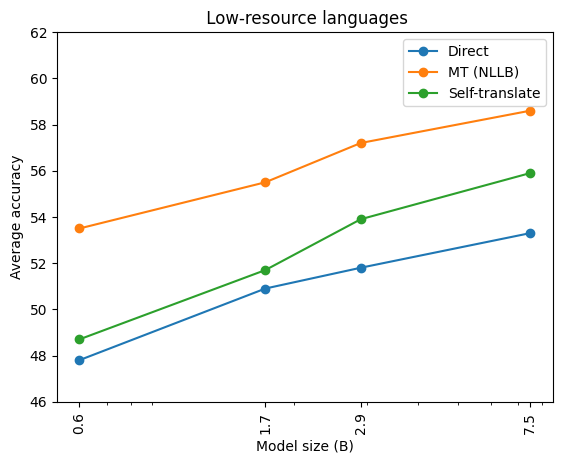

In [20]:
datasets_resources = ["xstory_cloze", "xcopa", "xnli"]

dfs_xglm = get_dataframes_model(all_results, datasets_resources, "xglm")

datasets_avg = ["XStoryCloze", "XCOPA", "XNLI", "", "", "", ""]

for i, df in enumerate(dfs_xglm):
    # display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "xglm", datasets_avg[i])

## XGLM

In [26]:
def get_dataframes_model(all_results, datasets, model_name, divide=False):
    dataset_keys = list(all_results.keys())
    if divide:
        df_avg_self = pd.DataFrame()
        df_avg_mt = pd.DataFrame()
    else:
        df_avg = pd.DataFrame()
    for dataset in datasets:
        dfs = []
        for dataset_key in dataset_keys:
            if dataset_key.startswith(dataset):
                # skip if dataset key contains a different model
                if model_name == "open_llama_v2":
                    if not any([model.lower() in models["open_llama_v2"] for model in all_results[dataset_key]]):
                        continue
                elif not any([model_name in model.lower() for model in all_results[dataset_key]]):
                    continue
                # skip if small nllb model
                if "600M" in dataset_key or "1.3B" in dataset_key:
                    continue
                results = pd.DataFrame(all_results[dataset_key]).T
                results["dataset"] = dataset_key
                results["model"] = [models_reverse[model] for model in results.index]
                results = results[results["model"] == model_name]
                results.drop(columns=["model"], inplace=True)
                results["model"] = model_name
                results["size"] = model_sizes[model_name][:len(results)]
                dfs.append(results)
        df_concat = pd.concat(dfs)
        df_concat = df_concat.sort_values(["size", "dataset"])
        df_concat = df_concat.reindex(columns=["model", "size", "dataset"] + [col for col in df_concat.columns if col not in ["model", "size", "dataset"]])
        df_concat["dataset"] = df_concat["dataset"].str.replace(dataset, "Direct")
        df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_few-shot", "Self-translate")
        df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
        df_concat = df_concat[df_concat["dataset"].isin(["Direct", "Self-translate"])]
        # divide into 2 dataframes, one for Direct and Self-MT, one for Self-MT and MT
        if divide:
            df_concat_self = df_concat[df_concat["dataset"].isin(["Direct", "Self-translate"])]
            df_concat_mt = df_concat[df_concat["dataset"].isin(["Self-MT", "MT (NLLB)"])]
            df_avg_self["model"] = df_concat_self["model"]
            df_avg_self["size"] = df_concat_self["size"]
            df_avg_self["dataset"] = df_concat_self["dataset"]
            df_avg_self[dataset] = df_concat_self["avg"]
            # repeat for mt 
            df_avg_mt["model"] = df_concat_mt["model"]
            df_avg_mt["size"] = df_concat_mt["size"]
            df_avg_mt["dataset"] = df_concat_mt["dataset"]
            df_avg_mt[dataset] = df_concat_mt["avg"]     
            yield df_concat_self
            yield df_concat_mt
        else:
            df_avg["model"] = df_concat["model"]
            df_avg["size"] = df_concat["size"]
            df_avg["dataset"] = df_concat["dataset"]
            df_avg[dataset] = df_concat["avg"]
            yield df_concat
    # add an avg column
    if divide:
        size = df_avg_self["size"]
        df_avg_self = df_avg_self.drop(columns=["size"])
        size = df_avg_mt["size"]
        df_avg_mt = df_avg_mt.drop(columns=["size"])
        df_avg_self["avg"] = df_avg_self.mean(axis=1).round(1)
        df_avg_mt["avg"] = df_avg_mt.mean(axis=1).round(1)
        df_avg_self["size"] = size
        df_avg_mt["size"] = size
        yield df_avg_self
        yield df_avg_mt
    else:
        size = df_avg["size"]
        df_avg = df_avg.drop(columns=["size"])
        df_avg["avg"] = df_avg.mean(axis=1).round(1)
        df_avg["size"] = size
        df_avg = df_avg.reindex(columns=["model", "size", "dataset"] + [col for col in df_avg.columns if col not in ["model", "size", "dataset"]])
        yield df_avg

In [19]:
def plot_size_df_datasets(df, model_name, title, langs=False):
    df.set_index("size", inplace=True)
    df.groupby("dataset")["avg"].plot(
        x="size", y="acc", title=f"{title}", ylabel="Average accuracy", xlabel="Model size (B)", legend=True, marker="o"
    )
    plt.xscale("log")
    plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
    if title == "":
        plt.savefig(f"plots/{model_name}.pdf", bbox_inches='tight')
    plt.show()
    # iterate all langs
    if langs:
        for lang in df.columns:
            if lang in ["dataset", "avg", "size"]:
                continue
            df.groupby("dataset")[lang].plot(x="size", y="acc", title=f"{title}_{lang}", ylabel="Accuracy", xlabel="Model size (B)", legend=True, marker="o")
            plt.xscale("log")
            plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
            plt.show()

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &  en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 & Self-translate & 52.2 &   \_ & 53.1 & 54.0 & 53.5 & 53.6 & 52.3 & 53.9 & 52.1 & 53.0 & 50.0 & 52.8 &  52.3 & 53.0 \\
 xglm &   0.6 &      MT (NLLB) & 58.1 &   \_ & 57.2 & 55.7 & 57.4 & 57.9 & 55.2 & 58.8 & 56.5 & 59.5 & 56.8 & 57.3 &  57.6 & 56.9 \\
 xglm &   1.7 & Self-translate & 55.4 &   \_ & 58.4 & 54.3 & 55.1 & 57.1 & 55.5 & 58.4 & 55.3 & 54.8 & 54.9 & 55.9 &  57.2 & 55.0 \\
 xglm &   1.7 &      MT (NLLB) & 61.9 &   \_ & 60.4 & 58.3 & 61.7 & 61.4 & 57.8 & 62.7 & 60.0 & 61.3 & 61.6 & 60.7 &  61.6 & 59.8 \\
 xglm &   2.9 & Self-translate & 56.3 &   \_ & 61.3 & 56.9 & 58.3 & 60.4 & 57.6 & 59.7 & 57.9 & 56.3 & 57.8 & 58.2 &  59.6 & 57.4 \\
 xglm &   2.9 &      MT (NLLB) & 63.0 &   \_ & 63.2 & 61.2 & 63.3 & 62.9 & 58.8 & 64.7 & 60.0 & 62.8 & 63.0 & 62.3 &  63.6 & 61.2 \\
 xglm &   7.5 & S

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3853517643.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


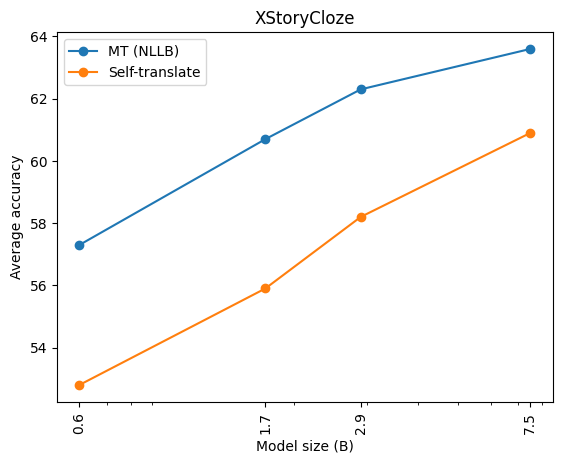

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 & Self-translate & 52.2 & 54.2 & 59.4 & 51.8 & 50.0 & 52.6 & 55.0 & 55.2 & 55.2 & 51.8 & 50.4 & 53.4 &  50.4 & 52.8 \\
 xglm &   0.6 &      MT (NLLB) & 60.0 & 61.0 & 60.4 & 61.8 & 50.4 & 59.4 & 61.6 & 58.8 & 62.4 & 61.8 & 60.2 & 59.8 &  60.2 & 58.5 \\
 xglm &   1.7 & Self-translate & 59.0 & 57.0 & 60.6 & 60.0 & 50.8 & 57.8 & 58.8 & 58.4 & 60.8 & 61.0 & 58.4 & 58.4 &  58.4 & 56.7 \\
 xglm &   1.7 &      MT (NLLB) & 65.6 & 62.8 & 63.4 & 65.6 & 50.4 & 62.2 & 63.8 & 61.0 & 63.8 & 64.0 & 62.6 & 62.3 &  62.6 & 61.0 \\
 xglm &   2.9 & Self-translate & 64.4 & 65.2 & 64.8 & 64.2 & 52.0 & 62.2 & 59.4 & 60.8 & 62.0 & 65.4 & 67.4 & 62.5 &  67.4 & 60.6 \\
 xglm &   2.9 &      MT (NLLB) & 69.2 & 65.4 & 67.2 & 70.8 & 51.0 & 64.8 & 65.2 & 64.0 & 66.4 & 67.2 & 67.0 & 65.3 &  67.0 & 63.1 \\
 xglm &   7.5 & 

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3853517643.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


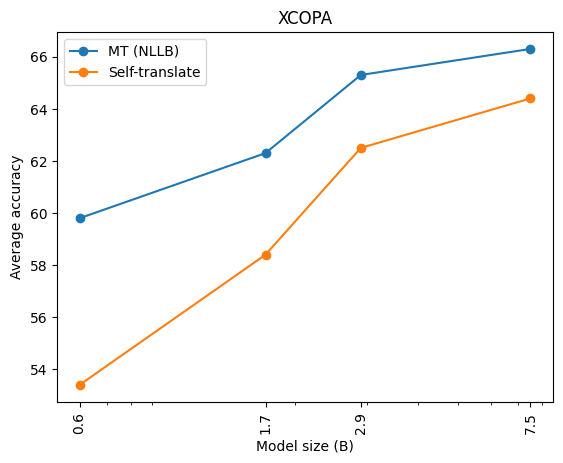

\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &   bg &   de &   el &  en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 & Self-translate & 40.2 & 43.9 & 43.9 & 42.2 &   \_ & 43.3 & 43.3 & 41.4 & 43.0 & 39.0 & 41.9 & 40.6 & 40.6 & 41.5 & 35.8 & 41.5 &  41.9 & 40.3 \\
 xglm &   0.6 &      MT (NLLB) & 46.9 & 47.1 & 46.6 & 46.6 &   \_ & 47.5 & 46.5 & 45.6 & 45.7 & 45.6 & 46.3 & 46.4 & 43.8 & 46.8 & 47.1 & 46.3 &  46.7 & 45.0 \\
 xglm &   1.7 & Self-translate & 44.2 & 46.8 & 47.0 & 46.1 &   \_ & 45.9 & 46.8 & 44.1 & 45.7 & 43.8 & 44.0 & 42.7 & 42.0 & 44.7 & 44.3 & 44.9 &  45.9 & 43.3 \\
 xglm &   1.7 &      MT (NLLB) & 47.3 & 47.8 & 48.8 & 48.1 &   \_ & 48.5 & 48.6 & 47.1 & 47.2 & 45.9 & 46.5 & 48.3 & 44.2 & 48.6 & 47.3 & 47.4 &  48.1 & 45.7 \\
 xglm &   2.9 & Self-translate & 43.9 & 48.1 & 48.4 & 47.3 &   \_ & 48.2 & 48.5 & 44.1 & 46.5 & 44.8 & 45.8 & 45.2 & 42.4 & 46.6 & 46.7 & 4

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3853517643.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


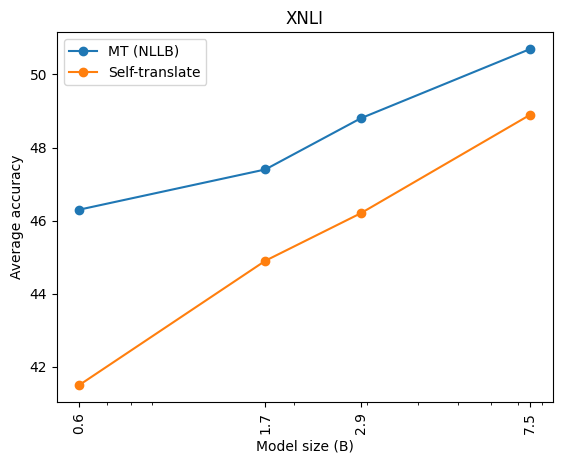

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


\begin{tabular}{lrlrrrrrrrrr}
\toprule
model &  size &        dataset &   de &  en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
 xglm &   0.6 & Self-translate & 51.1 &   \_ & 50.1 & 50.3 & 50.9 & 50.4 & 51.0 & 50.6 &  50.7 \\
 xglm &   0.6 &      MT (NLLB) & 53.5 &   \_ & 52.8 & 51.0 & 51.2 & 50.4 & 51.2 & 51.7 &  51.9 \\
 xglm &   1.7 & Self-translate & 50.0 &   \_ & 51.6 & 51.6 & 49.6 & 49.1 & 49.4 & 50.2 &  50.4 \\
 xglm &   1.7 &      MT (NLLB) & 51.9 &   \_ & 51.6 & 52.8 & 50.2 & 51.1 & 49.5 & 51.2 &  51.2 \\
 xglm &   2.9 & Self-translate & 54.9 &   \_ & 53.9 & 54.2 & 52.1 & 51.6 & 52.7 & 53.2 &  53.6 \\
 xglm &   2.9 &      MT (NLLB) & 56.5 &   \_ & 57.0 & 56.2 & 54.8 & 54.5 & 55.4 & 55.7 &  56.0 \\
 xglm &   7.5 & Self-translate & 57.7 &   \_ & 56.1 & 56.1 & 54.5 & 53.0 & 54.9 & 55.4 &  55.9 \\
 xglm &   7.5 &      MT (NLLB) & 59.6 &   \_ & 58.4 & 59.0 & 54.6 & 55.2 & 57.7 & 57.4 &  57.9 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/3853517643.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


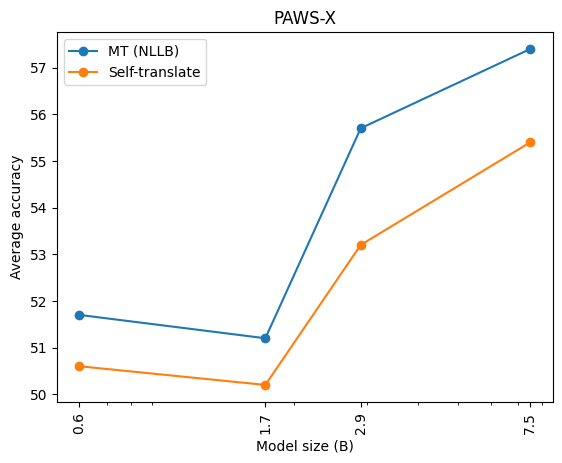

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &  bn &  de &  en &  es &  fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
 xglm &   0.6 & Self-translate & 0.0 & 2.0 &   \_ & 2.0 & 1.6 & 0.8 & 1.2 & 2.0 & 2.4 & 0.8 & 1.6 &  1.4 &   1.5 &  1.5 \\
 xglm &   0.6 &      MT (NLLB) & 1.2 & 1.2 &   \_ & 0.8 & 0.8 & 2.0 & 1.6 & 1.2 & 0.4 & 1.6 & 0.0 &  1.1 &   1.1 &  0.9 \\
 xglm &   1.7 & Self-translate & 1.2 & 2.0 &   \_ & 2.8 & 1.6 & 2.4 & 2.8 & 1.2 & 1.2 & 0.8 & 1.2 &  1.7 &   2.1 &  1.2 \\
 xglm &   1.7 &      MT (NLLB) & 2.0 & 2.4 &   \_ & 2.0 & 0.8 & 2.8 & 2.0 & 2.8 & 3.2 & 2.8 & 2.4 &  2.3 &   2.1 &  2.7 \\
 xglm &   2.9 & Self-translate & 0.8 & 1.2 &   \_ & 1.6 & 1.6 & 1.6 & 1.2 & 2.0 & 1.2 & 2.4 & 2.0 &  1.6 &   1.5 &  1.3 \\
 xglm &   2.9 &      MT (NLLB) & 2.8 & 2.4 &   \_ & 2.8 & 2.4 & 1.2 & 1.6 & 2.0 & 3.2 & 0.8 & 2.4 &  2.2 &   2.1 &  2.7 \\
 xglm &   7.5 & Self-translate & 0.0 & 0.4 &   \_ & 0.0 & 0.0 & 0.0 & 0.4 & 0.0 & 0.4 &

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3853517643.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


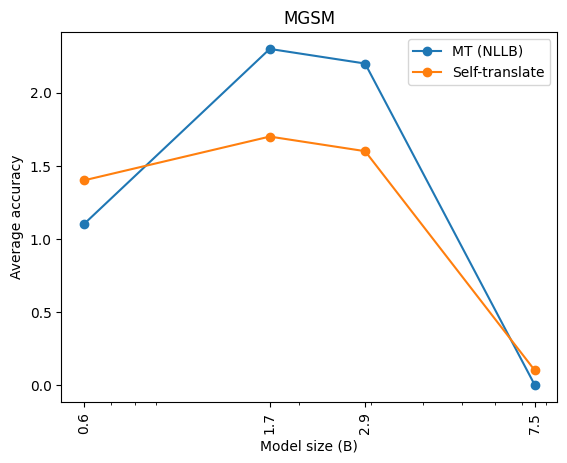

/tmp/ipykernel_1614158/2418502720.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/3853517643.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{llrrrrrrr}
\toprule
model &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg &  size \\
\midrule
 xglm & Self-translate &          52.8 &   53.4 &  41.5 &   50.6 &   1.4 & 39.9 &   0.6 \\
 xglm &      MT (NLLB) &          57.3 &   59.8 &  46.3 &   51.7 &   1.1 & 43.2 &   0.6 \\
 xglm & Self-translate &          55.9 &   58.4 &  44.9 &   50.2 &   1.7 & 42.2 &   1.7 \\
 xglm &      MT (NLLB) &          60.7 &   62.3 &  47.4 &   51.2 &   2.3 & 44.8 &   1.7 \\
 xglm & Self-translate &          58.2 &   62.5 &  46.2 &   53.2 &   1.6 & 44.3 &   2.9 \\
 xglm &      MT (NLLB) &          62.3 &   65.3 &  48.8 &   55.7 &   2.2 & 46.9 &   2.9 \\
 xglm & Self-translate &          60.9 &   64.4 &  48.9 &   55.4 &   0.1 & 45.9 &   7.5 \\
 xglm &      MT (NLLB) &          63.6 &   66.3 &  50.7 &   57.4 &   0.0 & 47.6 &   7.5 \\
\bottomrule
\end{tabular}



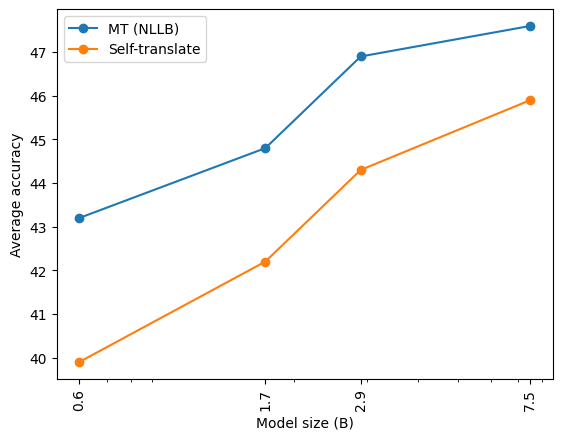

In [21]:
dfs_xglm = get_dataframes_model(all_results, datasets, "xglm")

datasets_avg = ["XStoryCloze", "XCOPA", "XNLI", "PAWS-X", "MGSM", ""]

for i, df in enumerate(dfs_xglm):
    # display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "xglm", datasets_avg[i])

## BLOOM

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
bloom &   0.6 &         Direct & 52.1 & 61.2 & 55.9 & 53.6 & 55.0 & 55.5 & 47.2 & 49.2 & 49.8 & 55.7 & 54.5 & 52.9 &  53.2 & 52.3 \\
bloom &   0.6 & Self-translate & 53.9 &    \_ & 53.1 & 53.9 & 55.7 & 54.6 & 51.0 & 48.8 & 53.7 & 53.4 & 50.5 & 52.9 &  50.8 & 53.5 \\
bloom &   1.7 &         Direct & 55.0 & 64.7 & 60.8 & 54.9 & 56.8 & 59.8 & 47.3 & 50.4 & 52.3 & 56.5 & 58.2 & 55.2 &  56.5 & 53.6 \\
bloom &   1.7 & Self-translate & 55.7 &    \_ & 62.3 & 54.3 & 55.8 & 57.9 & 51.0 & 50.4 & 52.9 & 54.5 & 59.8 & 55.5 &  57.5 & 53.7 \\
bloom &   3.0 &         Direct & 56.6 & 66.8 & 64.1 & 55.7 & 57.6 & 60.8 & 46.6 & 50.7 & 53.0 & 58.2 & 60.9 & 56.4 &  58.6 & 54.2 \\
bloom &   3.0 & Self-translate & 56.9 &    \_ & 62.7 & 57.5 & 59.6 & 60.2 & 49.9 & 51.2 & 54.6 & 57.5 & 62.4 & 57.2 &  58.8 & 55.8 \\
bloom &   7.1

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/1879524323.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


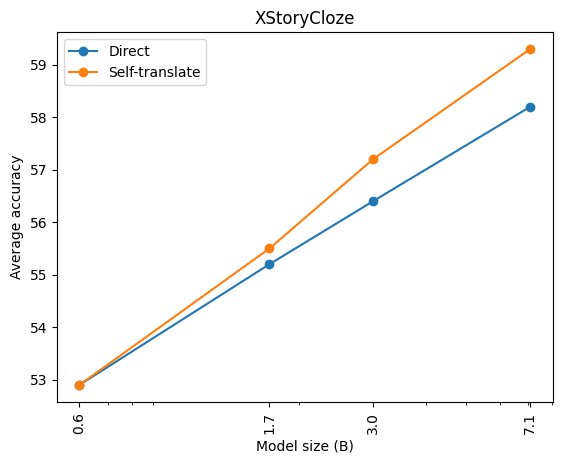

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/1879524323.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
bloom &   0.6 &         Direct & 49.0 & 50.2 & 59.2 & 50.8 & 50.2 & 51.6 & 55.8 & 54.4 & 53.0 & 61.0 & 58.6 & 54.0 &  58.6 & 51.4 \\
bloom &   0.6 & Self-translate & 48.6 & 52.4 & 54.6 & 48.0 & 47.0 & 47.8 & 52.6 & 48.6 & 51.0 & 53.4 & 56.8 & 51.0 &  56.8 & 49.7 \\
bloom &   1.7 &         Direct & 47.4 & 50.4 & 63.2 & 52.6 & 50.6 & 51.8 & 56.6 & 53.2 & 52.8 & 65.8 & 61.4 & 55.1 &  61.4 & 51.4 \\
bloom &   1.7 & Self-translate & 50.4 & 45.8 & 61.0 & 59.0 & 47.4 & 51.4 & 58.4 & 49.2 & 52.6 & 62.6 & 63.4 & 54.7 &  63.4 & 50.7 \\
bloom &   3.0 &         Direct & 49.2 & 50.2 & 69.2 & 51.6 & 50.6 & 51.4 & 58.0 & 52.6 & 53.4 & 68.8 & 62.0 & 56.1 &  62.0 & 51.9 \\
bloom &   3.0 & Self-translate & 50.0 & 51.0 & 62.4 & 59.6 & 49.6 & 57.8 & 60.4 & 49.6 & 48.4 & 65.8 & 69.4 & 56.7 &  69.4 & 53.8 \\
bloom &   7.1 & 

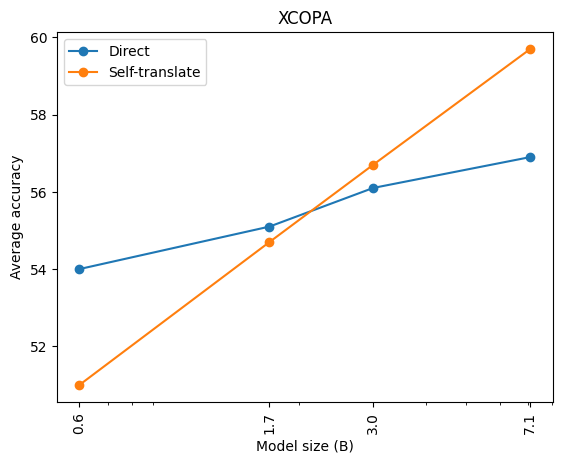

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/1879524323.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
bloom &   0.6 &         Direct & 33.4 & 33.4 & 34.8 & 33.3 & 49.5 & 45.2 & 45.3 & 40.8 & 34.0 & 33.2 & 33.6 & 33.4 & 37.1 & 40.5 & 34.0 & 36.6 &  38.7 & 37.0 \\
bloom &   0.6 & Self-translate & 45.6 & 37.8 & 42.1 & 33.6 &    \_ & 48.6 & 49.1 & 43.7 & 36.8 & 38.3 & 35.6 & 33.5 & 41.0 & 46.3 & 47.1 & 41.4 &  44.7 & 41.0 \\
bloom &   1.7 &         Direct & 33.6 & 35.4 & 40.6 & 34.0 & 50.1 & 47.8 & 48.2 & 44.0 & 39.3 & 34.5 & 33.4 & 34.9 & 40.5 & 46.2 & 36.2 & 39.2 &  42.4 & 39.7 \\
bloom &   1.7 & Self-translate & 45.1 & 38.2 & 42.0 & 37.3 &    \_ & 47.7 & 48.2 & 43.9 & 40.3 & 40.8 & 34.4 & 34.6 & 40.8 & 46.9 & 46.5 & 41.9 &  44.9 & 41.8 \\
bloom &   3.0 &         Direct & 33.4 & 37.9 & 40.4 & 33.2 & 53.4 & 49.1 & 49.2 & 45.5 & 41.4 & 35.8 & 33.4 & 33.8 & 40.0 & 46.5 & 37.4 

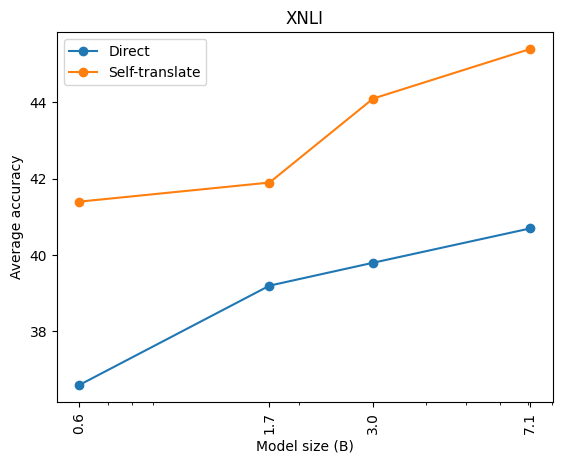

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/1879524323.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrr}
\toprule
model &  size &        dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
bloom &   0.6 &         Direct & 52.8 & 52.0 & 53.2 & 47.9 & 44.9 & 51.9 & 45.2 & 49.3 &  48.8 \\
bloom &   0.6 & Self-translate & 47.0 &    \_ & 49.5 & 50.7 & 44.7 & 48.3 & 50.2 & 48.4 &  48.4 \\
bloom &   1.7 &         Direct & 48.8 & 48.9 & 51.3 & 46.2 & 44.7 & 45.8 & 45.4 & 47.0 &  47.3 \\
bloom &   1.7 & Self-translate & 47.7 &    \_ & 48.9 & 49.6 & 45.9 & 47.4 & 48.3 & 48.0 &  48.1 \\
bloom &   3.0 &         Direct & 54.6 & 56.8 & 56.4 & 47.6 & 44.6 & 46.3 & 47.1 & 49.4 &  50.1 \\
bloom &   3.0 & Self-translate & 51.9 &    \_ & 54.9 & 55.4 & 48.6 & 49.1 & 52.8 & 52.1 &  52.7 \\
bloom &   7.1 &         Direct & 52.8 & 61.3 & 59.4 & 50.9 & 45.5 & 45.1 & 47.3 & 50.2 &  51.2 \\
bloom &   7.1 & Self-translate & 56.0 &    \_ & 58.1 & 57.6 & 50.5 & 48.5 & 55.8 & 54.4 &  55.6 \\
\bottomrule
\end{tabular}



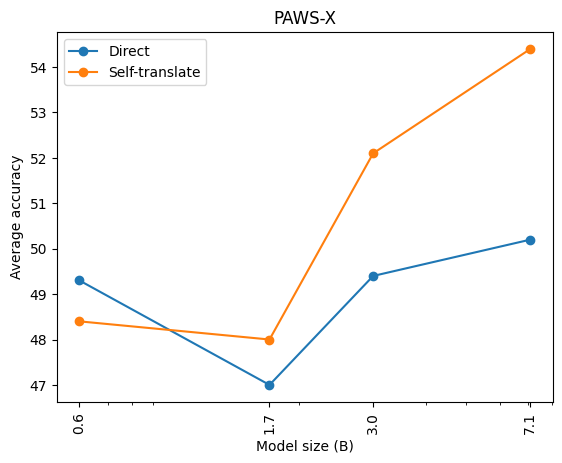

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/1879524323.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &  bn &  de &  en &  es &  fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
bloom &   0.6 &         Direct & 3.2 & 1.2 & 2.8 & 2.8 & 1.6 & 1.2 & 2.0 & 0.8 & 2.4 & 0.0 & 2.0 &  1.7 &   1.8 &  2.1 \\
bloom &   0.6 & Self-translate & 2.0 & 2.8 &   \_ & 2.0 & 3.2 & 0.8 & 0.0 & 1.2 & 0.8 & 0.0 & 2.0 &  1.5 &   1.8 &  1.3 \\
bloom &   1.7 &         Direct & 2.0 & 4.0 & 1.2 & 2.4 & 3.2 & 2.8 & 2.4 & 1.6 & 1.6 & 0.0 & 2.8 &  2.3 &   2.9 &  1.7 \\
bloom &   1.7 & Self-translate & 1.2 & 1.6 &   \_ & 1.6 & 4.0 & 1.2 & 2.0 & 2.8 & 1.2 & 0.0 & 2.0 &  1.8 &   2.1 &  1.7 \\
bloom &   3.0 &         Direct & 2.0 & 1.2 & 3.2 & 2.8 & 2.0 & 2.4 & 0.8 & 2.8 & 2.4 & 0.0 & 3.2 &  2.0 &   2.1 &  2.4 \\
bloom &   3.0 & Self-translate & 2.0 & 2.4 &   \_ & 2.4 & 3.2 & 1.6 & 1.2 & 1.2 & 3.2 & 1.6 & 2.0 &  2.1 &   2.1 &  2.1 \\
bloom &   7.1 &         Direct & 4.8 & 0.4 & 5.2 & 5.2 & 4.0 & 1.2 & 4.0 & 2.8 & 4.4 & 0.0

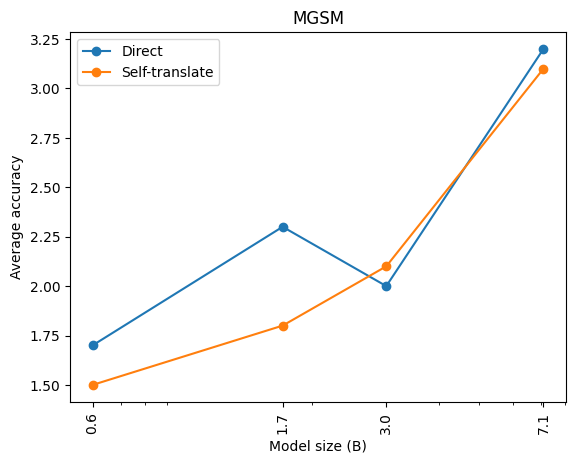

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/1879524323.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
model &  size &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
bloom &   0.6 &         Direct &          52.9 &   54.0 &  36.6 &   49.3 &   1.7 & 38.9 \\
bloom &   0.6 & Self-translate &          52.9 &   51.0 &  41.4 &   48.4 &   1.5 & 39.0 \\
bloom &   1.7 &         Direct &          55.2 &   55.1 &  39.2 &   47.0 &   2.3 & 39.8 \\
bloom &   1.7 & Self-translate &          55.5 &   54.7 &  41.9 &   48.0 &   1.8 & 40.4 \\
bloom &   3.0 &         Direct &          56.4 &   56.1 &  39.8 &   49.4 &   2.0 & 40.7 \\
bloom &   3.0 & Self-translate &          57.2 &   56.7 &  44.1 &   52.1 &   2.1 & 42.4 \\
bloom &   7.1 &         Direct &          58.2 &   56.9 &  40.7 &   50.2 &   3.2 & 41.8 \\
bloom &   7.1 & Self-translate &          59.3 &   59.7 &  45.4 &   54.4 &   3.1 & 44.4 \\
\bottomrule
\end{tabular}



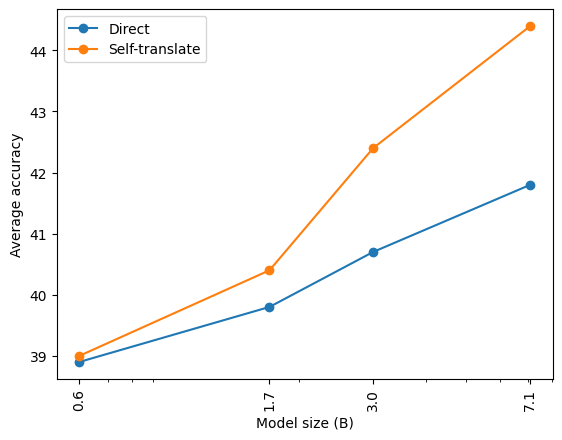

In [31]:
dfs_bloom = get_dataframes_model(all_results, datasets, "bloom")

for i, df in enumerate(dfs_bloom):
    # display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "bloom", datasets_avg[i])

## LLaMA

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/670778720.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &  en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
llama &   7.0 & Self-translate & 52.2 &   \_ & 68.0 & 50.0 & 51.9 & 56.5 & 50.2 & 66.8 & 50.6 & 51.4 & 60.4 & 55.8 &  65.1 & 50.8 \\
llama &   7.0 &      MT (NLLB) & 67.7 &   \_ & 68.4 & 65.4 & 68.5 & 68.3 & 62.5 & 70.1 & 64.3 & 65.5 & 67.2 & 66.8 &  68.6 & 65.2 \\
llama &  13.0 & Self-translate & 55.2 &   \_ & 72.1 & 50.8 & 53.7 & 59.3 & 51.8 & 70.4 & 48.4 & 51.8 & 63.2 & 57.7 &  68.6 & 51.3 \\
llama &  13.0 &      MT (NLLB) & 68.6 &   \_ & 70.0 & 66.4 & 70.0 & 69.0 & 62.8 & 71.7 & 66.0 & 67.7 & 69.1 & 68.1 &  70.3 & 66.6 \\
llama &  30.0 & Self-translate & 56.4 &   \_ & 74.0 & 48.8 & 60.2 & 62.6 & 51.0 & 71.4 & 48.9 & 49.9 & 67.0 & 59.0 &  70.8 & 51.8 \\
llama &  30.0 &      MT (NLLB) & 70.0 &   \_ & 71.5 & 66.6 & 70.0 & 69.3 & 63.6 & 73.3 & 67.0 & 66.9 & 69.0 & 68.7 &  71.3 & 66.8 \\
\bottomrule
\end{

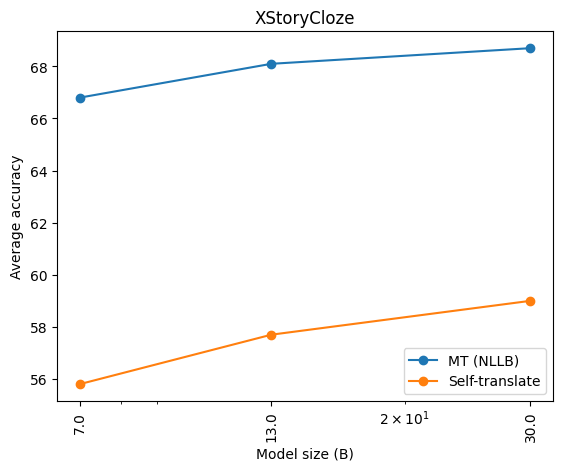

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
llama &   7.0 & Self-translate & 54.2 & 51.2 & 59.4 & 73.8 & 48.4 & 52.8 & 47.6 & 50.8 & 51.6 & 47.8 & 66.0 & 54.9 &  66.0 & 50.8 \\
llama &   7.0 &      MT (NLLB) & 72.6 & 68.2 & 71.0 & 75.4 & 52.2 & 67.4 & 70.2 & 62.2 & 72.6 & 71.2 & 71.6 & 68.6 &  71.6 & 66.1 \\
llama &  13.0 & Self-translate & 51.8 & 51.4 & 62.8 & 75.8 & 51.6 & 49.4 & 51.2 & 51.4 & 56.6 & 49.2 & 69.8 & 56.5 &  69.8 & 51.1 \\
llama &  13.0 &      MT (NLLB) & 73.2 & 70.0 & 72.8 & 76.8 & 51.6 & 70.2 & 71.8 & 64.8 & 73.2 & 75.2 & 75.2 & 70.4 &  75.2 & 67.4 \\
llama &  30.0 & Self-translate & 50.4 & 53.0 & 68.0 & 79.0 & 49.4 & 50.2 & 52.8 & 48.6 & 59.8 & 58.4 & 73.2 & 58.4 &  73.2 & 51.2 \\
llama &  30.0 &      MT (NLLB) & 75.2 & 71.2 & 73.2 & 80.6 & 52.6 & 70.6 & 72.2 & 64.6 & 74.2 & 75.0 & 76.8 & 71.5 &  76.8 & 68.4 \\
\bottomrule
\end

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/670778720.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


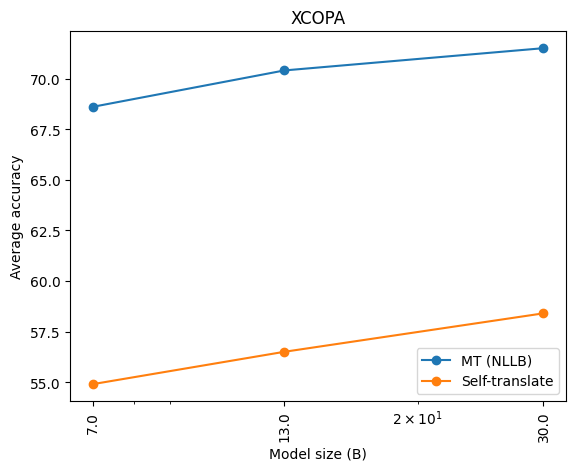

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/670778720.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   ar &   bg &   de &   el &  en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
llama &   7.0 & Self-translate & 40.7 & 48.7 & 50.6 & 43.5 &   \_ & 49.8 & 49.5 & 39.7 & 48.0 & 34.8 & 36.3 & 38.0 & 36.4 & 39.9 & 46.1 & 43.0 &  48.8 & 37.0 \\
llama &   7.0 &      MT (NLLB) & 48.6 & 49.3 & 49.9 & 50.1 &   \_ & 50.4 & 50.1 & 48.5 & 48.3 & 46.5 & 46.4 & 48.0 & 45.5 & 49.2 & 49.3 & 48.6 &  49.6 & 46.8 \\
llama &  13.0 & Self-translate & 35.3 & 34.7 & 35.3 & 35.1 &   \_ & 36.0 & 35.8 & 35.4 & 35.0 & 34.9 & 34.8 & 34.6 & 34.9 & 35.4 & 34.4 & 35.1 &  35.3 & 35.1 \\
llama &  13.0 &      MT (NLLB) & 34.1 & 35.5 & 35.2 & 35.4 &   \_ & 35.2 & 35.3 & 35.4 & 35.1 & 35.1 & 34.0 & 34.5 & 35.1 & 34.8 & 35.9 & 35.0 &  35.3 & 35.2 \\
llama &  30.0 & Self-translate & 42.2 & 47.6 & 47.7 & 44.8 &   \_ & 48.1 & 47.8 & 41.4 & 47.3 & 37.3 & 37.4 & 42.0 & 38.9 & 41.6 & 44.3 & 4

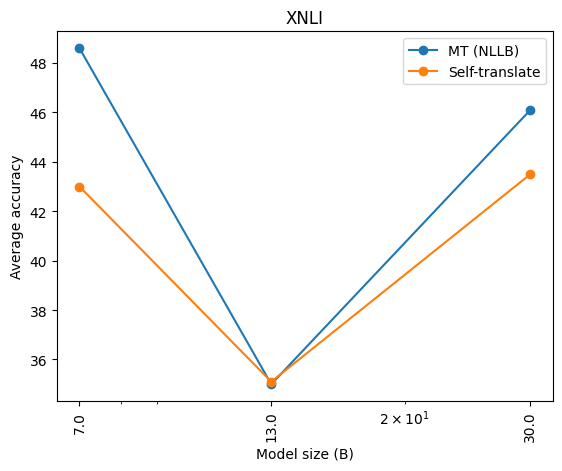

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/670778720.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrr}
\toprule
model &  size &        dataset &   de &  en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
llama &   7.0 & Self-translate & 59.8 &   \_ & 60.7 & 59.2 & 53.9 & 52.5 & 55.8 & 57.0 &  57.9 \\
llama &   7.0 &      MT (NLLB) & 59.9 &   \_ & 60.6 & 60.1 & 57.6 & 57.5 & 57.3 & 58.8 &  59.1 \\
llama &  13.0 & Self-translate & 52.9 &   \_ & 52.5 & 52.9 & 51.2 & 51.6 & 51.5 & 52.1 &  52.2 \\
llama &  13.0 &      MT (NLLB) & 53.6 &   \_ & 54.7 & 53.6 & 55.9 & 54.5 & 53.9 & 54.4 &  54.3 \\
llama &  30.0 & Self-translate & 56.5 &   \_ & 56.8 & 58.1 & 54.5 & 52.1 & 55.5 & 55.6 &  56.3 \\
llama &  30.0 &      MT (NLLB) & 56.5 &   \_ & 58.5 & 57.6 & 54.9 & 54.9 & 54.6 & 56.2 &  56.4 \\
\bottomrule
\end{tabular}



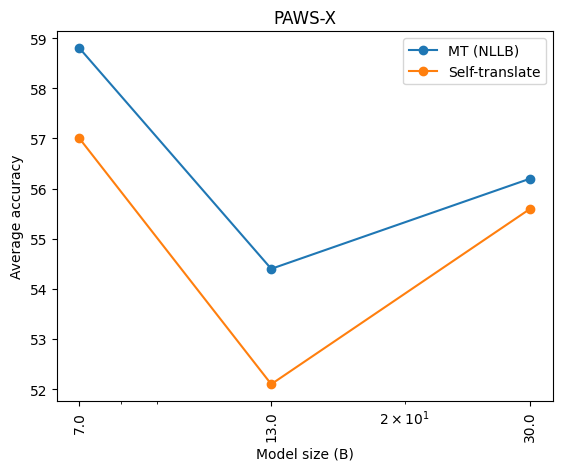

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size &        dataset &   bn &   de &  en &   es &   fr &   ja &   ru &   sw &   te &   th &   zh &  avg &  high &  low \\
\midrule
llama &   7.0 & Self-translate &  2.0 & 11.2 &   \_ & 11.2 & 12.4 &  4.8 & 10.8 &  1.2 &  0.4 &  2.4 &  4.8 &  6.1 &   9.2 &  1.2 \\
llama &   7.0 &      MT (NLLB) & 10.0 & 12.4 &   \_ & 12.0 &  9.6 & 10.8 & 10.8 & 12.0 &  9.6 &  8.4 & 11.2 & 10.7 &  11.1 & 10.5 \\
llama &  13.0 & Self-translate &  3.6 & 17.6 &   \_ & 20.4 & 18.0 &  9.2 & 15.2 &  3.6 &  0.0 &  1.6 & 10.4 & 10.0 &  15.1 &  2.4 \\
llama &  13.0 &      MT (NLLB) & 16.8 & 20.0 &   \_ & 20.8 & 15.2 & 15.2 & 15.6 & 19.2 & 14.0 & 14.0 & 14.4 & 16.5 &  16.9 & 16.7 \\
llama &  30.0 & Self-translate &  8.0 & 34.4 &   \_ &  9.6 & 24.4 & 20.8 & 29.6 &  6.4 &  0.4 &  3.6 & 25.6 & 16.3 &  24.1 &  4.9 \\
llama &  30.0 &      MT (NLLB) & 28.4 & 32.4 &   \_ & 31.2 & 35.2 & 29.2 & 26.4 & 32.0 & 25.6 & 20.0 & 25.6 & 28.6 &  30.0 & 28.7 \\
\bottomrule
\end{

/tmp/ipykernel_1614158/2418502720.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/670778720.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


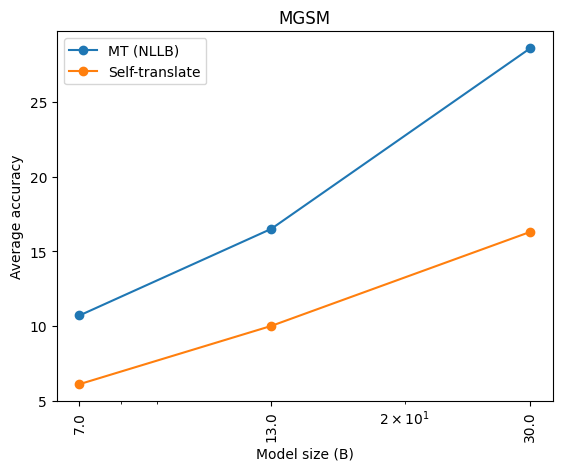

/tmp/ipykernel_1614158/2418502720.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/670778720.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{llrrrrrrr}
\toprule
model &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg &  size \\
\midrule
llama & Self-translate &          55.8 &   54.9 &  43.0 &   57.0 &   6.1 & 43.4 &   7.0 \\
llama &      MT (NLLB) &          66.8 &   68.6 &  48.6 &   58.8 &  10.7 & 50.7 &   7.0 \\
llama & Self-translate &          57.7 &   56.5 &  35.1 &   52.1 &  10.0 & 42.3 &  13.0 \\
llama &      MT (NLLB) &          68.1 &   70.4 &  35.0 &   54.4 &  16.5 & 48.9 &  13.0 \\
llama & Self-translate &          59.0 &   58.4 &  43.5 &   55.6 &  16.3 & 46.6 &  30.0 \\
llama &      MT (NLLB) &          68.7 &   71.5 &  46.1 &   56.2 &  28.6 & 54.2 &  30.0 \\
\bottomrule
\end{tabular}



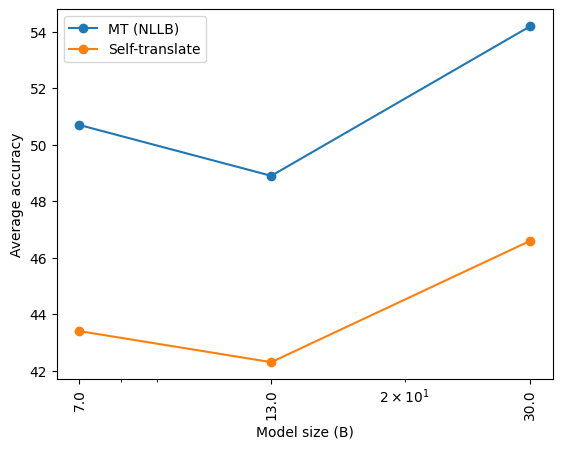

In [22]:
dfs_llama = get_dataframes_model(all_results, datasets, "llama")

for i, df in enumerate(dfs_llama):
    # display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "llama", datasets_avg[i])

## LLaMA 2

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
  model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
llama-2 &   7.0 &         Direct & 49.7 & 77.0 & 67.3 & 50.4 & 53.7 & 59.2 & 48.0 & 63.0 & 50.6 & 54.2 & 59.6 & 55.6 &  63.3 & 51.4 \\
llama-2 &   7.0 & Self-translate & 52.0 &    \_ & 68.3 & 48.6 & 57.2 & 65.3 & 49.2 & 69.8 & 49.0 & 52.6 & 65.9 & 57.8 &  68.0 & 51.3 \\
llama-2 &  13.0 &         Direct & 51.0 & 78.4 & 69.1 & 50.6 & 55.7 & 63.5 & 48.0 & 66.2 & 51.0 & 54.0 & 63.4 & 57.2 &  66.2 & 51.9 \\
llama-2 &  13.0 &         Direct & 50.5 & 81.1 & 70.2 & 51.4 & 55.6 & 63.2 & 48.6 & 68.3 & 51.0 & 54.0 & 66.4 & 57.9 &  68.3 & 52.1 \\
llama-2 &  13.0 & Self-translate & 55.3 &    \_ & 72.9 & 50.6 & 60.6 & 67.7 & 51.0 & 69.4 & 51.4 & 50.8 & 69.6 & 59.9 &  70.6 & 52.9 \\
llama-2 &  13.0 & Self-translate & 53.3 &    \_ & 74.4 & 48.7 & 57.8 & 68.6 & 50.2 & 70.9 & 49.6 & 51.6 & 68.1 & 59.3 &  71.1 & 51.6 \\

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/499680832.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


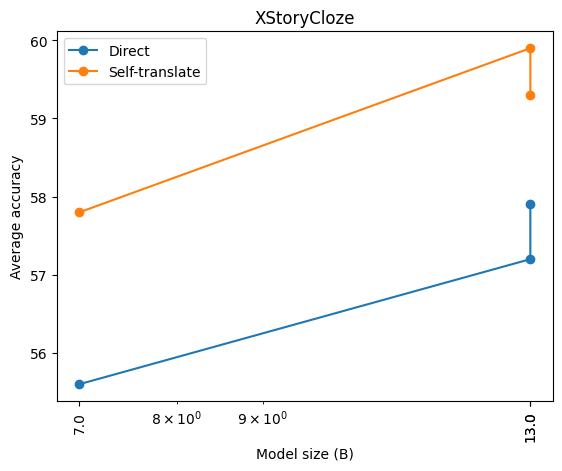

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/499680832.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
  model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
llama-2 &   7.0 &         Direct & 48.6 & 50.4 & 62.6 & 65.8 & 51.6 & 52.2 & 53.4 & 56.2 & 54.6 & 62.8 & 65.0 & 56.7 &  65.0 & 51.2 \\
llama-2 &   7.0 & Self-translate & 52.8 & 51.0 & 69.4 & 75.0 & 49.6 & 52.2 & 50.2 & 52.2 & 59.4 & 66.6 & 73.8 & 59.3 &  73.8 & 51.2 \\
llama-2 &  13.0 &         Direct & 46.6 & 54.2 & 66.8 & 69.4 & 48.4 & 51.4 & 54.4 & 56.6 & 57.6 & 64.6 & 70.0 & 58.2 &  70.0 & 51.0 \\
llama-2 &  13.0 &         Direct & 44.8 & 52.0 & 62.2 & 67.4 & 51.2 & 50.0 & 53.0 & 54.2 & 56.2 & 60.4 & 66.8 & 56.2 &  66.8 & 50.2 \\
llama-2 &  13.0 & Self-translate & 53.8 & 56.4 & 72.6 & 76.6 & 47.2 & 50.2 & 49.0 & 54.2 & 64.2 & 73.4 & 76.6 & 61.3 &  76.6 & 51.3 \\
llama-2 &  13.0 & Self-translate & 50.6 & 51.8 & 70.8 & 77.0 & 44.6 & 48.6 & 51.2 & 48.4 & 58.6 & 66.4 & 75.4 & 58.5 &  75.4 & 49.4 \\
\b

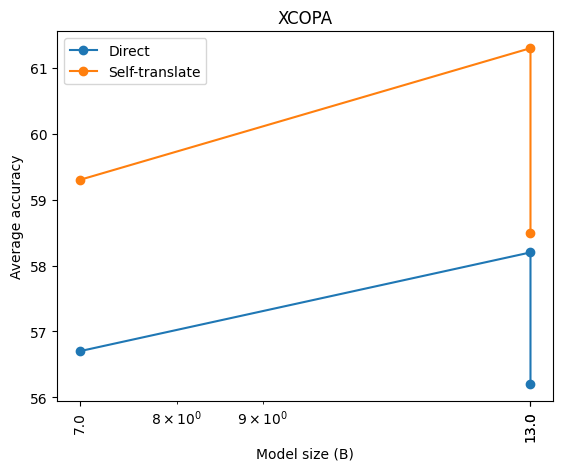

\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
  model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
llama-2 &   7.0 &         Direct & 34.7 & 41.5 & 46.8 & 36.3 & 56.7 & 42.2 & 50.1 & 38.5 & 42.5 & 34.8 & 36.3 & 39.2 & 33.4 & 37.5 & 35.7 & 39.2 &  43.5 & 35.6 \\
llama-2 &   7.0 & Self-translate & 44.3 & 52.0 & 53.3 & 47.6 &    \_ & 55.0 & 54.4 & 44.3 & 52.0 & 37.1 & 41.1 & 45.3 & 38.8 & 51.3 & 49.8 & 47.6 &  52.9 & 40.1 \\
llama-2 &  13.0 &         Direct & 33.8 & 38.9 & 48.8 & 40.3 & 52.5 & 45.3 & 47.4 & 41.8 & 45.2 & 34.5 & 35.6 & 36.8 & 33.6 & 38.9 & 36.3 & 39.8 &  44.6 & 36.6 \\
llama-2 &  13.0 &         Direct & 34.2 & 42.1 & 45.2 & 37.3 & 54.1 & 41.3 & 47.1 & 39.1 & 44.5 & 33.8 & 34.1 & 35.5 & 34.2 & 38.0 & 43.4 & 39.3 &  44.3 & 35.7 \\
llama-2 &  13.0 & Self-translate & 43.6 & 48.7 & 50.3 & 45.9 &    \_ & 50.6 & 50.9 & 43.8 & 49.1 & 37.0 & 40.9 & 44.1 & 41.1 & 

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/499680832.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


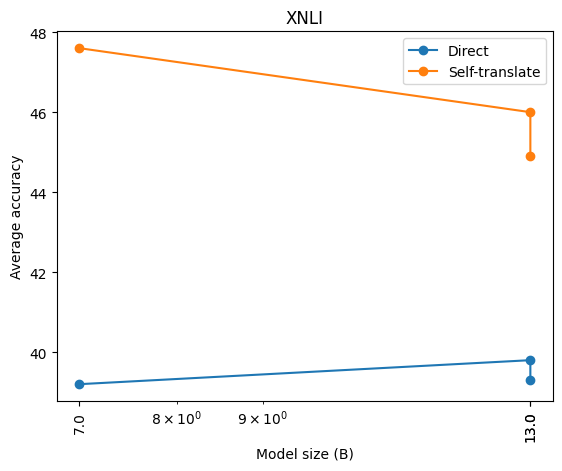

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/499680832.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrr}
\toprule
  model &  size &        dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
llama-2 &   7.0 &         Direct & 63.3 & 68.9 & 64.7 & 58.6 & 50.2 & 52.1 & 58.2 & 57.9 &  59.0 \\
llama-2 &   7.0 & Self-translate & 65.0 &    \_ & 64.3 & 64.5 & 58.9 & 56.5 & 58.6 & 61.3 &  62.3 \\
llama-2 &  13.0 &         Direct & 61.6 & 63.6 & 55.8 & 54.2 & 45.2 & 47.3 & 50.5 & 52.4 &  53.5 \\
llama-2 &  13.0 &         Direct & 61.9 & 66.0 & 54.6 & 59.2 & 48.9 & 46.9 & 49.6 & 53.5 &  54.8 \\
llama-2 &  13.0 & Self-translate & 57.9 &    \_ & 57.0 & 57.2 & 52.5 & 52.2 & 54.2 & 55.2 &  55.8 \\
llama-2 &  13.0 & Self-translate & 60.2 &    \_ & 58.8 & 59.4 & 55.2 & 53.8 & 58.0 & 57.6 &  58.3 \\
\bottomrule
\end{tabular}



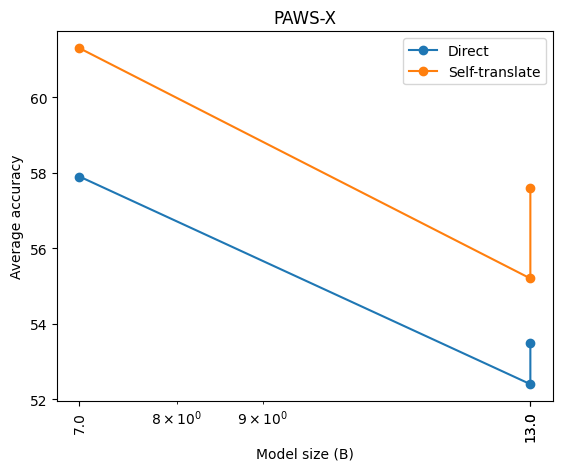

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/499680832.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
  model &  size &        dataset &   bn &   de &   en &   es &   fr &   ja &   ru &  sw &  te &  th &   zh &  avg &  high &  low \\
\midrule
llama-2 &   7.0 &         Direct &  0.0 &  2.0 &  4.4 &  4.0 &  3.2 &  1.6 &  1.6 & 3.6 & 0.0 & 0.0 &  1.6 &  1.8 &   2.3 &  1.2 \\
llama-2 &   7.0 & Self-translate &  2.0 & 13.2 &    \_ & 12.4 & 13.2 &  5.2 & 11.6 & 2.0 & 0.0 & 2.0 & 10.4 &  7.2 &  11.0 &  1.3 \\
llama-2 &  13.0 &         Direct &  0.0 & 24.0 & 31.6 & 30.4 & 24.8 & 11.6 & 16.0 & 3.2 & 0.0 & 0.0 & 22.0 & 13.2 &  21.5 &  1.1 \\
llama-2 &  13.0 &         Direct &  0.0 & 33.2 & 38.0 & 28.0 & 29.2 & 13.2 & 27.2 & 6.0 & 0.0 & 0.0 & 25.2 & 16.2 &  26.0 &  2.0 \\
llama-2 &  13.0 & Self-translate & 10.0 & 30.4 &    \_ & 29.6 & 28.0 & 25.6 & 29.2 & 6.0 & 0.0 & 4.0 & 29.6 & 19.2 &  28.7 &  5.3 \\
llama-2 &  13.0 & Self-translate &  5.6 & 38.0 &    \_ & 36.0 & 34.8 & 28.8 & 34.4 & 5.2 & 0.0 & 2.4 & 26.8 & 21.2 &  33.1 &  3.6 \\
\bottomrule
\end{tab

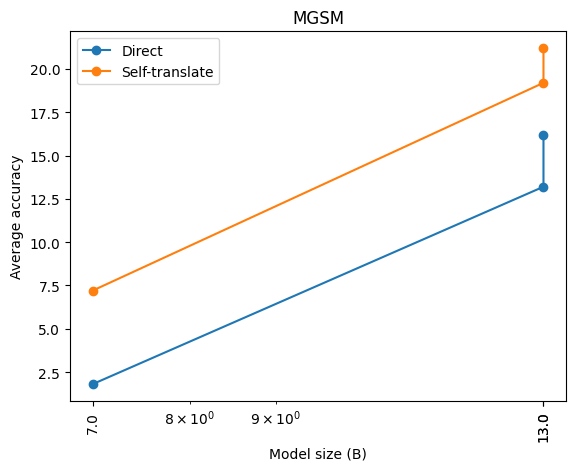

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/499680832.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
  model &  size &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
llama-2 &   7.0 &         Direct &          55.6 &   56.7 &  39.2 &   57.9 &   1.8 & 42.2 \\
llama-2 &   7.0 & Self-translate &          57.8 &   59.3 &  47.6 &   61.3 &   7.2 & 46.6 \\
llama-2 &  13.0 &         Direct &          57.2 &   58.2 &  39.8 &   52.4 &  13.2 & 44.2 \\
llama-2 &  13.0 &         Direct &          57.9 &   56.2 &  39.3 &   53.5 &  16.2 & 44.6 \\
llama-2 &  13.0 & Self-translate &          59.9 &   61.3 &  46.0 &   55.2 &  19.2 & 48.3 \\
llama-2 &  13.0 & Self-translate &          59.3 &   58.5 &  44.9 &   57.6 &  21.2 & 48.3 \\
\bottomrule
\end{tabular}



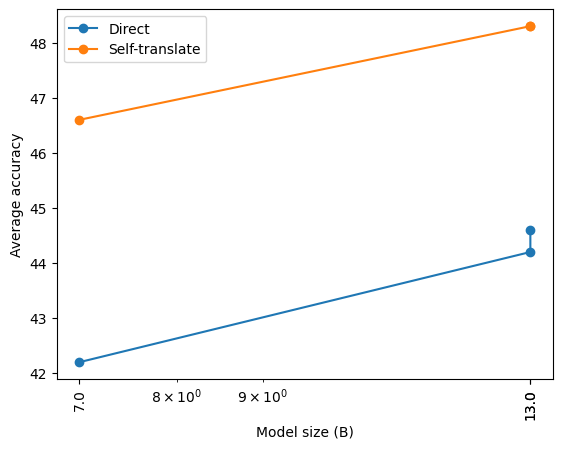

In [32]:
dfs_llama = get_dataframes_model(all_results, datasets, "llama-2")

for i, df in enumerate(dfs_llama):
    # display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "llama-2", datasets_avg[i])

## RedPajama

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
    model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
redpajama &   3.0 &         Direct & 47.7 & 72.0 & 58.4 & 50.7 & 50.0 & 49.3 & 48.4 & 54.1 & 50.5 & 53.1 & 51.4 & 51.4 &  54.6 & 50.5 \\
redpajama &   3.0 & Self-translate & 50.4 &    \_ & 60.5 & 49.0 & 48.7 & 49.7 & 52.0 & 56.9 & 50.2 & 48.9 & 57.0 & 52.3 &  58.1 & 49.8 \\
redpajama &   7.0 &         Direct & 47.9 & 75.1 & 63.7 & 51.3 & 51.2 & 51.8 & 49.1 & 58.1 & 51.7 & 53.5 & 54.7 & 53.3 &  58.8 & 51.4 \\
redpajama &   7.0 & Self-translate & 51.7 &    \_ & 66.5 & 50.5 & 51.7 & 52.5 & 49.1 & 61.2 & 47.9 & 49.5 & 58.4 & 53.9 &  62.0 & 49.7 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/2593648049.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


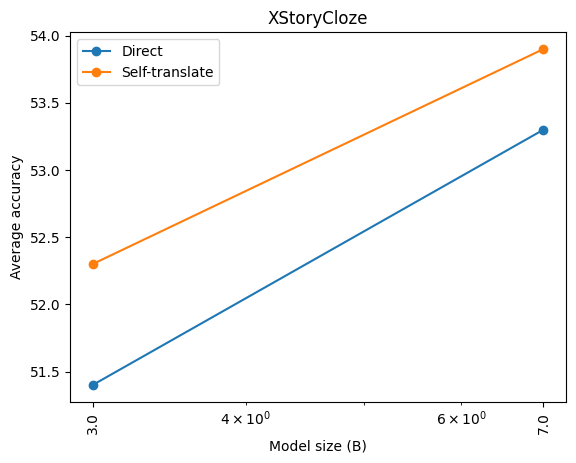

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/2593648049.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
    model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
redpajama &   3.0 &         Direct & 50.8 & 51.4 & 51.6 & 57.6 & 50.4 & 52.6 & 55.6 & 54.4 & 53.6 & 52.6 & 52.2 & 53.0 &  52.2 & 52.2 \\
redpajama &   3.0 & Self-translate & 52.0 & 53.4 & 55.6 & 64.8 & 50.2 & 50.2 & 50.2 & 51.0 & 50.0 & 46.2 & 60.0 & 53.1 &  60.0 & 51.2 \\
redpajama &   7.0 &         Direct & 49.0 & 49.6 & 54.2 & 60.2 & 48.0 & 51.8 & 54.8 & 53.0 & 51.4 & 49.6 & 55.8 & 52.5 &  55.8 & 50.6 \\
redpajama &   7.0 & Self-translate & 51.2 & 52.6 & 58.2 & 69.4 & 49.4 & 54.2 & 50.6 & 50.8 & 52.8 & 51.2 & 66.4 & 55.2 &  66.4 & 51.6 \\
\bottomrule
\end{tabular}



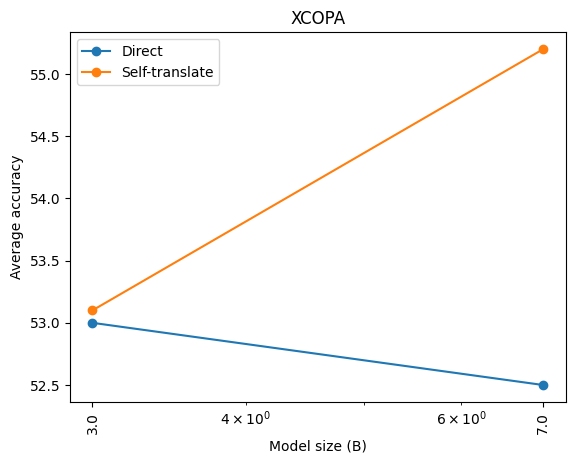

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/2593648049.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
    model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
redpajama &   3.0 &         Direct & 33.6 & 36.0 & 42.3 & 34.3 & 53.8 & 38.8 & 49.0 & 34.3 & 38.8 & 34.9 & 33.5 & 34.3 & 33.5 & 33.9 & 31.6 & 36.3 &  40.1 & 34.2 \\
redpajama &   3.0 & Self-translate & 37.3 & 47.4 & 49.0 & 39.1 &    \_ & 51.3 & 50.8 & 36.8 & 48.0 & 35.3 & 36.8 & 34.6 & 35.3 & 38.2 & 44.7 & 41.8 &  48.8 & 35.8 \\
redpajama &   7.0 &         Direct & 34.8 & 39.5 & 46.6 & 36.3 & 53.5 & 41.5 & 48.7 & 34.3 & 46.8 & 33.4 & 33.5 & 36.4 & 33.7 & 34.1 & 35.7 & 38.2 &  43.9 & 33.8 \\
redpajama &   7.0 & Self-translate & 39.9 & 49.5 & 50.0 & 42.2 &    \_ & 51.1 & 51.2 & 37.7 & 48.4 & 33.3 & 36.6 & 37.5 & 35.1 & 38.4 & 45.7 & 42.6 &  49.3 & 35.4 \\
\bottomrule
\end{tabular}



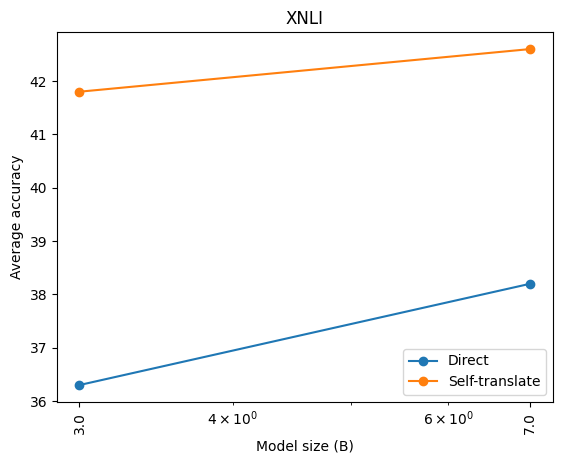

\begin{tabular}{lrlrrrrrrrrr}
\toprule
    model &  size &        dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
redpajama &   3.0 &         Direct & 56.0 & 61.3 & 54.6 & 56.3 & 56.1 & 45.4 & 47.0 & 52.6 &  54.0 \\
redpajama &   3.0 & Self-translate & 57.6 &    \_ & 59.0 & 59.5 & 55.5 & 52.5 & 56.8 & 56.8 &  57.7 \\
redpajama &   7.0 &         Direct & 59.2 & 60.2 & 62.3 & 55.9 & 53.2 & 49.6 & 46.9 & 54.5 &  55.5 \\
redpajama &   7.0 & Self-translate & 59.7 &    \_ & 61.7 & 61.2 & 52.4 & 53.1 & 56.2 & 57.4 &  58.2 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/2593648049.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


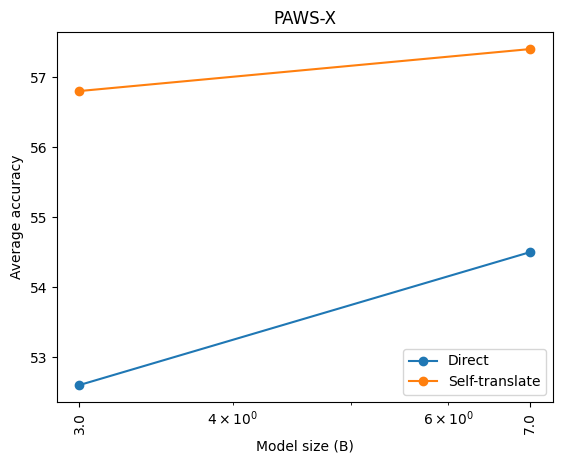

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/2593648049.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
    model &  size &        dataset &  bn &  de &  en &  es &  fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
redpajama &   3.0 &         Direct & 0.0 & 1.6 & 4.0 & 0.4 & 1.2 & 1.2 & 2.0 & 2.8 & 0.0 & 0.0 & 2.0 &  1.1 &   1.4 &  0.9 \\
redpajama &   3.0 & Self-translate & 0.4 & 2.8 &   \_ & 1.2 & 2.4 & 0.8 & 1.6 & 2.4 & 1.2 & 0.0 & 1.6 &  1.4 &   1.7 &  1.3 \\
redpajama &   7.0 &         Direct & 0.0 & 2.4 & 1.6 & 5.2 & 2.4 & 2.0 & 2.4 & 2.4 & 0.0 & 0.0 & 3.2 &  2.0 &   2.9 &  0.8 \\
redpajama &   7.0 & Self-translate & 0.4 & 4.0 &   \_ & 6.8 & 6.0 & 2.8 & 5.6 & 2.0 & 0.4 & 0.4 & 3.6 &  3.2 &   4.8 &  0.9 \\
\bottomrule
\end{tabular}



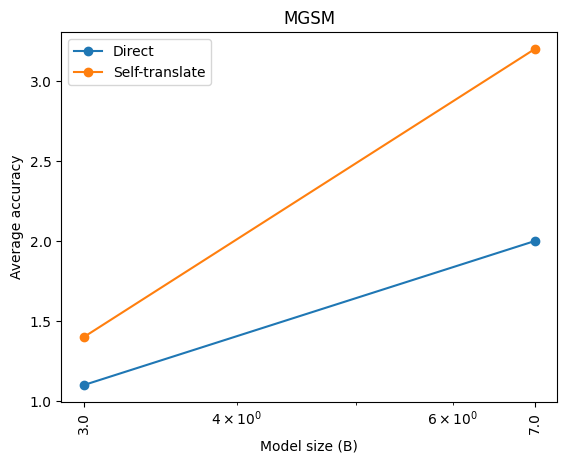

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/2593648049.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
    model &  size &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
redpajama &   3.0 &         Direct &          51.4 &   53.0 &  36.3 &   52.6 &   1.1 & 38.9 \\
redpajama &   3.0 & Self-translate &          52.3 &   53.1 &  41.8 &   56.8 &   1.4 & 41.1 \\
redpajama &   7.0 &         Direct &          53.3 &   52.5 &  38.2 &   54.5 &   2.0 & 40.1 \\
redpajama &   7.0 & Self-translate &          53.9 &   55.2 &  42.6 &   57.4 &   3.2 & 42.5 \\
\bottomrule
\end{tabular}



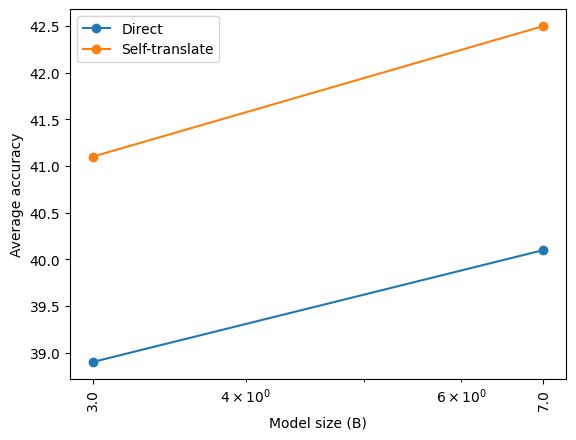

In [34]:
dfs_redpajama = get_dataframes_model(all_results, datasets, "redpajama")

for i, df in enumerate(dfs_redpajama):
    # display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "redpajama", datasets_avg[i])

## Open LLaMA

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
     model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
open\_llama &   3.0 &         Direct & 48.2 & 72.9 & 58.7 & 50.1 & 50.2 & 49.7 & 47.5 & 52.9 & 50.6 & 52.7 & 49.7 & 51.0 &  53.8 & 50.2 \\
open\_llama &   3.0 & Self-translate & 49.6 &    \_ & 63.1 & 50.1 & 52.5 & 51.2 & 52.8 & 57.7 & 50.0 & 51.4 & 55.1 & 53.4 &  58.6 & 51.4 \\
open\_llama &   7.0 &         Direct & 49.3 & 75.4 & 62.2 & 50.4 & 50.2 & 51.2 & 47.8 & 57.2 & 50.4 & 53.0 & 52.1 & 52.4 &  57.2 & 50.4 \\
open\_llama &   7.0 & Self-translate & 50.6 &    \_ & 67.4 & 51.0 & 52.3 & 53.8 & 52.8 & 65.2 & 50.0 & 51.0 & 60.6 & 55.5 &  64.4 & 51.4 \\
open\_llama &  13.0 &         Direct & 50.2 & 77.0 & 65.5 & 51.2 & 52.4 & 52.9 & 47.9 & 60.3 & 50.8 & 52.5 & 54.5 & 53.8 &  60.1 & 51.0 \\
open\_llama &  13.0 & Self-translate & 52.9 &    \_ & 64.9 & 49.4 & 54.8 & 57.0 & 52.8 & 62.3 & 50.4 & 51.5 & 58

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/640181487.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


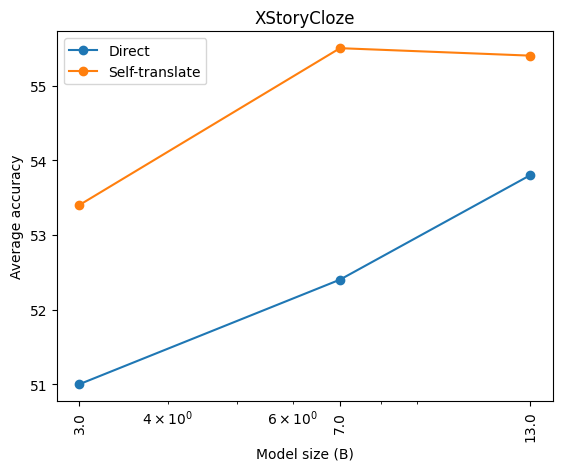

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/640181487.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
     model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
open\_llama &   3.0 &         Direct & 47.4 & 51.2 & 51.0 & 56.6 & 51.6 & 51.6 & 53.4 & 53.2 & 54.6 & 51.6 & 53.8 & 52.4 &  53.8 & 51.0 \\
open\_llama &   3.0 & Self-translate & 53.4 & 51.8 & 54.2 & 63.0 & 48.8 & 51.6 & 48.4 & 50.0 & 49.4 & 47.0 & 60.4 & 52.5 &  60.4 & 50.8 \\
open\_llama &   7.0 &         Direct & 47.4 & 51.0 & 53.8 & 61.0 & 49.4 & 51.6 & 55.4 & 53.0 & 55.4 & 50.0 & 54.0 & 52.9 &  54.0 & 51.0 \\
open\_llama &   7.0 & Self-translate & 54.4 & 51.0 & 56.8 & 67.6 & 50.4 & 50.8 & 49.2 & 48.0 & 50.4 & 52.2 & 62.0 & 53.9 &  62.0 & 51.2 \\
open\_llama &  13.0 &         Direct & 50.2 & 51.0 & 55.8 & 64.2 & 49.8 & 53.0 & 53.6 & 56.6 & 54.2 & 50.6 & 55.2 & 54.0 &  55.2 & 51.5 \\
open\_llama &  13.0 & Self-translate & 53.4 & 54.4 & 60.6 & 70.2 & 48.8 & 54.4 & 48.6 & 50.6 & 53.8 & 55.0 & 66.2 

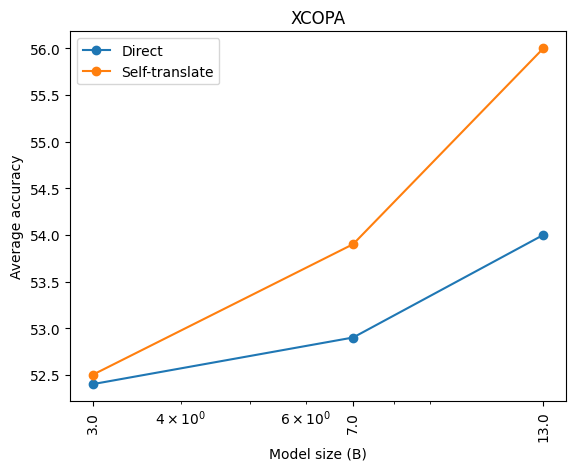

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/640181487.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
     model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
open\_llama &   3.0 &         Direct & 33.4 & 35.4 & 41.4 & 33.5 & 48.5 & 37.5 & 42.6 & 34.9 & 35.9 & 34.3 & 34.9 & 33.9 & 33.3 & 35.3 & 33.6 & 35.7 &  38.2 & 34.2 \\
open\_llama &   3.0 & Self-translate & 37.3 & 45.6 & 46.7 & 38.0 &    \_ & 46.7 & 47.5 & 33.8 & 46.1 & 34.7 & 33.9 & 33.8 & 33.1 & 35.1 & 43.2 & 39.7 &  46.0 & 33.9 \\
open\_llama &   7.0 &         Direct & 33.8 & 35.5 & 42.1 & 34.2 & 55.0 & 44.2 & 47.4 & 34.1 & 38.7 & 34.0 & 34.4 & 36.0 & 33.3 & 35.9 & 34.1 & 37.0 &  41.3 & 33.8 \\
open\_llama &   7.0 & Self-translate & 39.8 & 50.3 & 51.6 & 41.6 &    \_ & 53.6 & 52.9 & 38.0 & 50.8 & 34.7 & 34.0 & 36.7 & 33.9 & 39.0 & 46.8 & 43.1 &  51.1 & 35.5 \\
open\_llama &  13.0 &         Direct & 33.4 & 40.5 & 47.3 & 36.1 & 55.1 & 45.1 & 48.6 & 35.2 & 45.1 & 35.3 

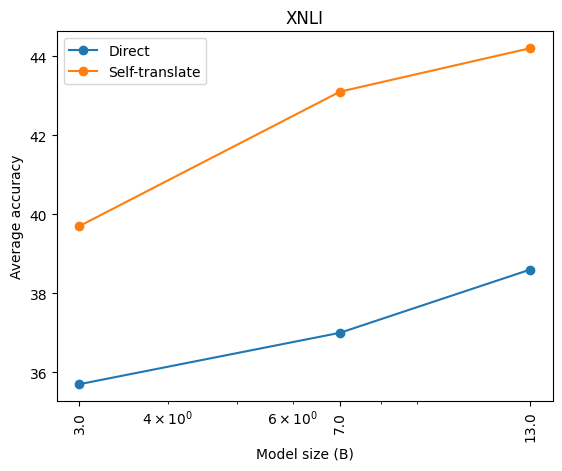

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/640181487.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrr}
\toprule
     model &  size &        dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
open\_llama &   3.0 &         Direct & 50.8 & 54.3 & 53.4 & 52.7 & 44.0 & 45.0 & 44.5 & 48.4 &  49.1 \\
open\_llama &   3.0 & Self-translate & 52.8 &    \_ & 53.6 & 54.2 & 52.4 & 52.0 & 53.4 & 53.1 &  53.3 \\
open\_llama &   7.0 &         Direct & 57.8 & 63.9 & 60.0 & 55.4 & 44.3 & 47.1 & 46.4 & 51.8 &  52.8 \\
open\_llama &   7.0 & Self-translate & 60.3 &    \_ & 60.6 & 61.0 & 53.0 & 51.1 & 55.1 & 56.9 &  58.0 \\
open\_llama &  13.0 &         Direct & 61.6 & 64.3 & 60.0 & 58.0 & 45.4 & 45.1 & 46.2 & 52.7 &  54.2 \\
open\_llama &  13.0 & Self-translate & 61.9 &    \_ & 62.5 & 64.3 & 54.0 & 51.0 & 54.1 & 58.0 &  59.4 \\
\bottomrule
\end{tabular}



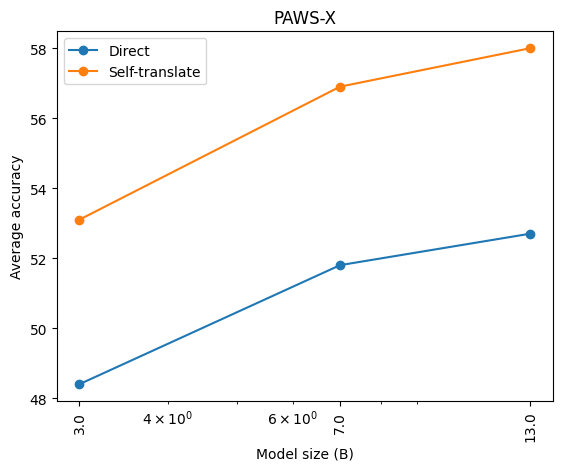

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/640181487.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
     model &  size &        dataset &  bn &  de &   en &   es &   fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
open\_llama &   3.0 &         Direct & 0.0 & 1.6 &  3.6 &  2.0 &  3.6 & 0.0 & 1.6 & 2.4 & 0.0 & 0.0 & 0.0 &  1.1 &   1.5 &  0.8 \\
open\_llama &   3.0 & Self-translate & 0.0 & 3.6 &    \_ &  5.2 &  4.0 & 1.6 & 1.6 & 1.2 & 0.0 & 0.0 & 1.6 &  1.9 &   2.9 &  0.4 \\
open\_llama &   7.0 &         Direct & 0.0 & 3.2 &  6.4 &  4.8 &  7.6 & 0.0 & 2.4 & 0.8 & 0.0 & 0.0 & 0.0 &  1.9 &   3.0 &  0.3 \\
open\_llama &   7.0 & Self-translate & 0.0 & 7.2 &    \_ &  6.4 &  6.8 & 3.2 & 7.6 & 0.8 & 0.4 & 0.0 & 3.6 &  3.6 &   5.8 &  0.4 \\
open\_llama &  13.0 &         Direct & 0.0 & 8.4 & 14.8 & 11.6 &  9.6 & 0.0 & 4.4 & 1.2 & 0.0 & 0.0 & 0.0 &  3.5 &   5.7 &  0.4 \\
open\_llama &  13.0 & Self-translate & 0.4 & 8.8 &    \_ & 11.2 & 12.8 & 2.8 & 9.2 & 2.4 & 0.4 & 0.0 & 5.2 &  5.3 &   8.3 &  1.1 \\
\bottomrule
\end{tabular}



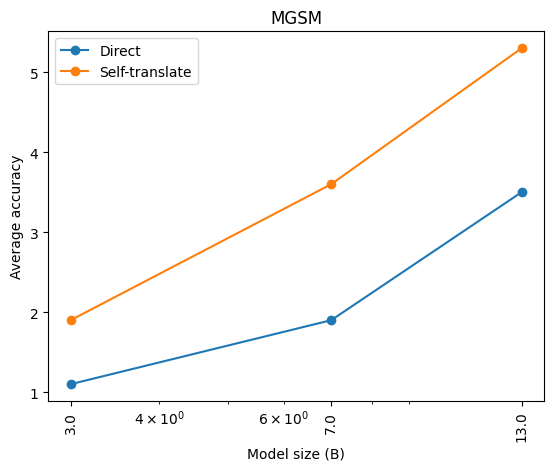

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/640181487.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
     model &  size &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
open\_llama &   3.0 &         Direct &          51.0 &   52.4 &  35.7 &   48.4 &   1.1 & 37.7 \\
open\_llama &   3.0 & Self-translate &          53.4 &   52.5 &  39.7 &   53.1 &   1.9 & 40.1 \\
open\_llama &   7.0 &         Direct &          52.4 &   52.9 &  37.0 &   51.8 &   1.9 & 39.2 \\
open\_llama &   7.0 & Self-translate &          55.5 &   53.9 &  43.1 &   56.9 &   3.6 & 42.6 \\
open\_llama &  13.0 &         Direct &          53.8 &   54.0 &  38.6 &   52.7 &   3.5 & 40.5 \\
open\_llama &  13.0 & Self-translate &          55.4 &   56.0 &  44.2 &   58.0 &   5.3 & 43.8 \\
\bottomrule
\end{tabular}



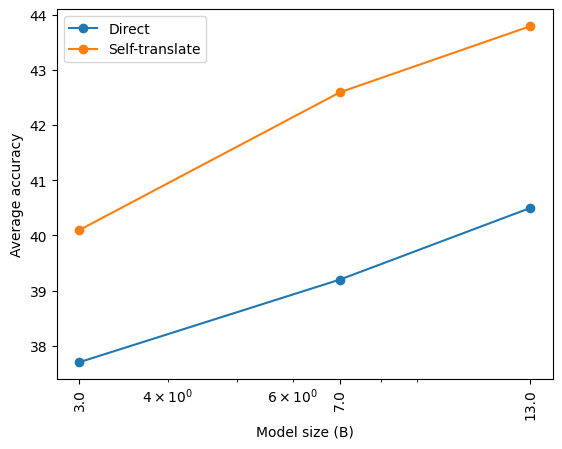

In [35]:
dfs_open_llama = get_dataframes_model(all_results, datasets, "open_llama")

for i, df in enumerate(dfs_open_llama):
    #display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "open_llama", datasets_avg[i])

## Open LLaMA V2

\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
        model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
open\_llama\_v2 &   3.0 &         Direct & 47.7 & 74.1 & 60.6 & 50.6 & 49.2 & 51.6 & 47.3 & 55.6 & 50.2 & 52.9 & 56.5 & 52.2 &  57.6 & 50.0 \\
open\_llama\_v2 &   3.0 & Self-translate & 49.5 &    \_ & 63.9 & 49.7 & 49.9 & 55.5 & 52.0 & 62.7 & 52.1 & 49.2 & 61.0 & 54.5 &  62.5 & 50.6 \\
open\_llama\_v2 &   7.0 &         Direct & 47.7 & 76.8 & 64.9 & 50.6 & 49.4 & 55.1 & 48.3 & 58.8 & 50.8 & 53.5 & 59.4 & 53.9 &  61.0 & 50.5 \\
open\_llama\_v2 &   7.0 & Self-translate & 48.8 &    \_ & 68.0 & 50.1 & 50.4 & 61.7 & 51.9 & 65.3 & 48.7 & 49.2 & 62.5 & 55.7 &  65.3 & 50.1 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3725565741.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


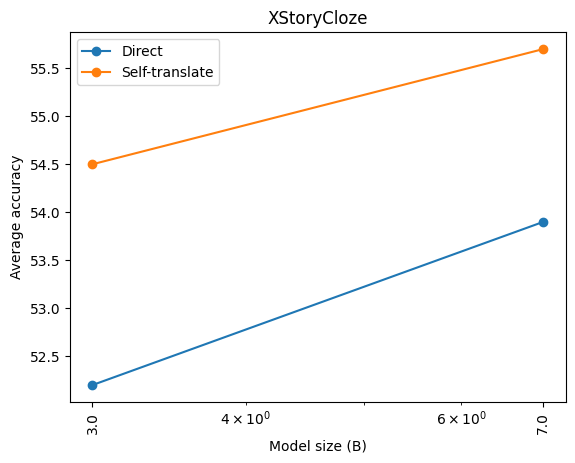

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3725565741.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
        model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
open\_llama\_v2 &   3.0 &         Direct & 48.8 & 50.0 & 55.0 & 57.6 & 49.4 & 51.6 & 56.4 & 55.8 & 55.2 & 51.8 & 59.0 & 53.7 &  59.0 & 51.2 \\
open\_llama\_v2 &   3.0 & Self-translate & 57.0 & 53.8 & 60.4 & 67.8 & 51.4 & 49.8 & 49.2 & 52.2 & 50.0 & 54.0 & 65.8 & 55.6 &  65.8 & 52.2 \\
open\_llama\_v2 &   7.0 &         Direct & 48.6 & 53.0 & 56.6 & 61.6 & 49.8 & 50.8 & 55.8 & 56.0 & 53.8 & 53.0 & 59.8 & 54.4 &  59.8 & 51.6 \\
open\_llama\_v2 &   7.0 & Self-translate & 50.6 & 51.2 & 62.8 & 71.2 & 51.8 & 54.0 & 47.4 & 54.0 & 54.6 & 55.0 & 73.8 & 56.9 &  73.8 & 51.0 \\
\bottomrule
\end{tabular}



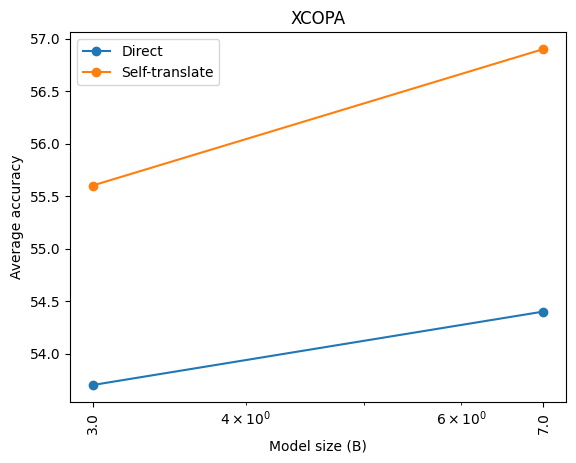

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3725565741.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
        model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
open\_llama\_v2 &   3.0 &         Direct & 33.3 & 37.2 & 44.6 & 33.8 & 53.0 & 38.4 & 45.0 & 33.6 & 42.6 & 33.7 & 34.2 & 35.0 & 33.4 & 35.8 & 34.2 & 36.8 &  41.0 & 33.6 \\
open\_llama\_v2 &   3.0 & Self-translate & 38.3 & 48.2 & 50.1 & 42.5 &    \_ & 51.4 & 51.3 & 37.6 & 48.2 & 36.3 & 39.9 & 38.4 & 35.5 & 41.8 & 48.2 & 43.4 &  49.8 & 36.5 \\
open\_llama\_v2 &   7.0 &         Direct & 34.1 & 40.4 & 47.5 & 35.2 & 52.1 & 40.8 & 47.3 & 34.5 & 44.6 & 34.2 & 35.4 & 34.6 & 33.4 & 37.1 & 36.0 & 38.2 &  43.2 & 34.0 \\
open\_llama\_v2 &   7.0 & Self-translate & 40.2 & 49.1 & 51.3 & 43.2 &    \_ & 51.1 & 51.0 & 40.3 & 50.1 & 35.7 & 40.1 & 42.1 & 35.7 & 45.7 & 48.2 & 44.6 &  50.3 & 37.2 \\
\bottomrule
\end{tabular}



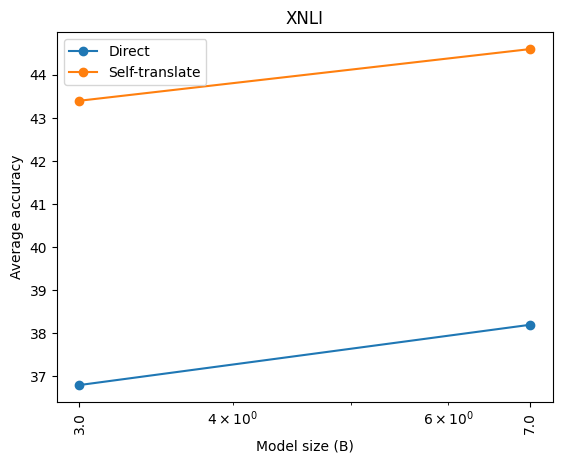

\begin{tabular}{lrlrrrrrrrrr}
\toprule
        model &  size &        dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
open\_llama\_v2 &   3.0 &         Direct & 51.1 & 57.6 & 52.1 & 51.0 & 44.9 & 44.9 & 50.2 & 49.0 &  49.9 \\
open\_llama\_v2 &   3.0 & Self-translate & 54.4 &    \_ & 55.0 & 55.1 & 51.8 & 49.5 & 50.7 & 52.8 &  53.4 \\
open\_llama\_v2 &   7.0 &         Direct & 58.0 & 63.5 & 58.6 & 55.0 & 44.8 & 47.4 & 49.9 & 52.3 &  53.3 \\
open\_llama\_v2 &   7.0 & Self-translate & 59.6 &    \_ & 60.7 & 59.9 & 53.8 & 51.3 & 51.6 & 56.2 &  57.1 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3725565741.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


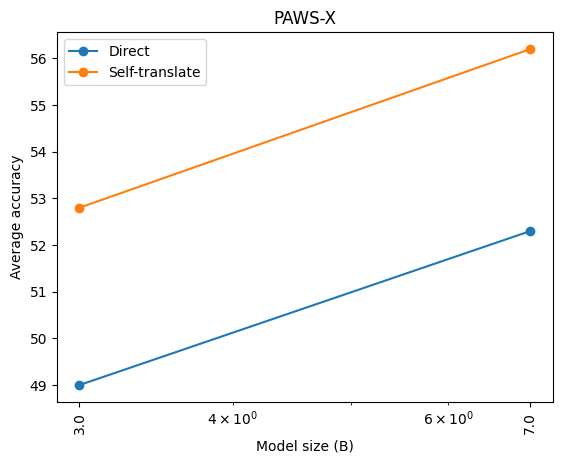

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/3725565741.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
        model &  size &        dataset &  bn &   de &   en &   es &   fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
open\_llama\_v2 &   3.0 &         Direct & 0.0 &  4.4 &  5.6 &  2.8 &  2.8 & 1.6 & 3.6 & 1.6 & 0.0 & 0.0 & 5.2 &  2.2 &   3.4 &  0.5 \\
open\_llama\_v2 &   3.0 & Self-translate & 1.2 &  4.0 &    \_ &  5.6 &  4.8 & 2.8 & 4.8 & 1.2 & 0.0 & 1.6 & 4.4 &  3.0 &   4.4 &  0.8 \\
open\_llama\_v2 &   7.0 &         Direct & 0.0 &  6.8 & 10.4 &  7.2 &  6.4 & 2.0 & 5.6 & 2.4 & 0.0 & 0.0 & 6.0 &  3.6 &   5.7 &  0.8 \\
open\_llama\_v2 &   7.0 & Self-translate & 1.6 & 10.4 &    \_ & 11.2 & 10.8 & 5.6 & 8.4 & 1.2 & 0.0 & 2.0 & 6.0 &  5.7 &   8.7 &  0.9 \\
\bottomrule
\end{tabular}



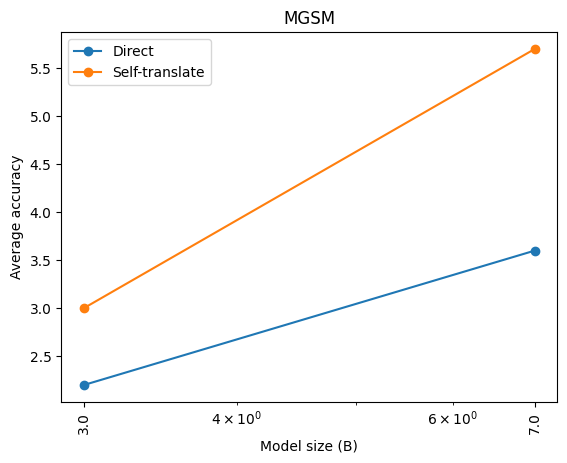

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)
/tmp/ipykernel_1614158/3725565741.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
        model &  size &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
open\_llama\_v2 &   3.0 &         Direct &          52.2 &   53.7 &  36.8 &   49.0 &   2.2 & 38.8 \\
open\_llama\_v2 &   3.0 & Self-translate &          54.5 &   55.6 &  43.4 &   52.8 &   3.0 & 41.9 \\
open\_llama\_v2 &   7.0 &         Direct &          53.9 &   54.4 &  38.2 &   52.3 &   3.6 & 40.5 \\
open\_llama\_v2 &   7.0 & Self-translate &          55.7 &   56.9 &  44.6 &   56.2 &   5.7 & 43.8 \\
\bottomrule
\end{tabular}



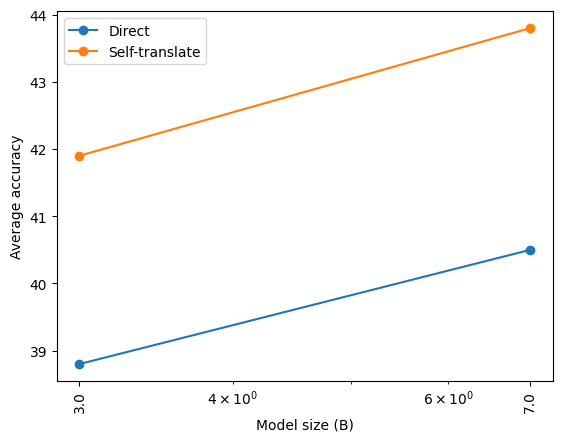

In [36]:
dfs_open_llama_v2 = get_dataframes_model(all_results, datasets, "open_llama_v2")

for i, df in enumerate(dfs_open_llama_v2):
    #display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "open_llama_v2", datasets_avg[i])

## PolyLM

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,high,low
polylm-1.7b,polylm,1.7,Direct,50.3,61.1,56.2,51.5,47.8,56.5,47.7,54.7,47.3,51.2,55.0,51.8,55.3,49.1
polylm-1.7b,polylm,1.7,Self-translate,52.9,NaN,54.7,51.6,49.7,55.0,51.2,55.0,50.7,51.5,53.7,52.6,54.5,50.9
polylm-13b,polylm,13.0,Direct,56.3,75.0,65.8,51.4,49.0,63.7,47.6,64.1,49.0,53.4,62.9,56.3,64.3,50.1
polylm-multialpaca-13b,polylm,13.0,Direct,59.9,80.6,69.0,51.1,49.2,69.5,46.9,69.4,48.4,53.9,70.6,58.8,69.7,49.9
polylm-13b,polylm,13.0,Self-translate,58.3,NaN,67.3,49.8,50.2,64.1,51.4,67.5,48.0,49.7,67.8,57.4,67.5,49.8
polylm-multialpaca-13b,polylm,13.0,Self-translate,63.6,NaN,72.3,50.4,50.5,68.8,51.1,70.6,49.5,50.8,72.7,60.0,71.9,50.5


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
 model &  size &        dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
polylm &   1.7 &         Direct & 50.3 & 61.1 & 56.2 & 51.5 & 47.8 & 56.5 & 47.7 & 54.7 & 47.3 & 51.2 & 55.0 & 51.8 &  55.3 & 49.1 \\
polylm &   1.7 & Self-translate & 52.9 &    \_ & 54.7 & 51.6 & 49.7 & 55.0 & 51.2 & 55.0 & 50.7 & 51.5 & 53.7 & 52.6 &  54.5 & 50.9 \\
polylm &  13.0 &         Direct & 56.3 & 75.0 & 65.8 & 51.4 & 49.0 & 63.7 & 47.6 & 64.1 & 49.0 & 53.4 & 62.9 & 56.3 &  64.3 & 50.1 \\
polylm &  13.0 &         Direct & 59.9 & 80.6 & 69.0 & 51.1 & 49.2 & 69.5 & 46.9 & 69.4 & 48.4 & 53.9 & 70.6 & 58.8 &  69.7 & 49.9 \\
polylm &  13.0 & Self-translate & 58.3 &    \_ & 67.3 & 49.8 & 50.2 & 64.1 & 51.4 & 67.5 & 48.0 & 49.7 & 67.8 & 57.4 &  67.5 & 49.8 \\
polylm &  13.0 & Self-translate & 63.6 &    \_ & 72.3 & 50.4 & 50.5 & 68.8 & 51.1 & 70.6 & 49.5 & 50.8 & 72.7 & 60.0 &  71.9 & 50.5 \\
\botto

/tmp/ipykernel_1614158/135789990.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


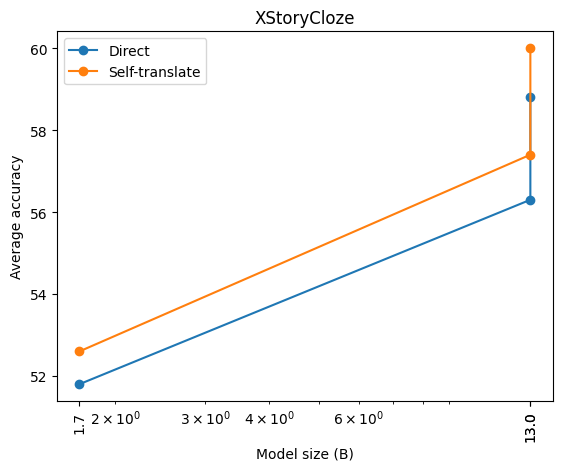

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,high,low
polylm-1.7b,polylm,1.7,Direct,47.4,49.4,59.4,55.2,49.6,52.6,55.0,56.2,56.4,60.8,55.2,54.3,55.2,50.8
polylm-1.7b,polylm,1.7,Self-translate,53.6,49.4,57.6,51.4,50.0,50.0,50.6,52.0,51.0,58.8,60.4,53.2,60.4,50.7
polylm-13b,polylm,13.0,Direct,49.8,50.4,70.2,66.0,50.4,51.8,55.0,58.6,57.8,70.8,67.0,58.9,67.0,51.5
polylm-multialpaca-13b,polylm,13.0,Direct,49.0,51.8,71.2,67.2,49.0,52.4,55.4,58.6,59.4,72.4,74.8,60.1,74.8,51.5
polylm-13b,polylm,13.0,Self-translate,48.0,54.0,69.8,67.8,46.6,51.8,49.8,63.2,64.2,71.2,77.6,60.4,77.6,50.0
polylm-multialpaca-13b,polylm,13.0,Self-translate,52.4,55.0,70.0,69.0,47.4,48.0,48.0,61.2,65.8,72.8,75.0,60.4,75.0,50.2


/tmp/ipykernel_1614158/135789990.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
 model &  size &        dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
polylm &   1.7 &         Direct & 47.4 & 49.4 & 59.4 & 55.2 & 49.6 & 52.6 & 55.0 & 56.2 & 56.4 & 60.8 & 55.2 & 54.3 &  55.2 & 50.8 \\
polylm &   1.7 & Self-translate & 53.6 & 49.4 & 57.6 & 51.4 & 50.0 & 50.0 & 50.6 & 52.0 & 51.0 & 58.8 & 60.4 & 53.2 &  60.4 & 50.7 \\
polylm &  13.0 &         Direct & 49.8 & 50.4 & 70.2 & 66.0 & 50.4 & 51.8 & 55.0 & 58.6 & 57.8 & 70.8 & 67.0 & 58.9 &  67.0 & 51.5 \\
polylm &  13.0 &         Direct & 49.0 & 51.8 & 71.2 & 67.2 & 49.0 & 52.4 & 55.4 & 58.6 & 59.4 & 72.4 & 74.8 & 60.1 &  74.8 & 51.5 \\
polylm &  13.0 & Self-translate & 48.0 & 54.0 & 69.8 & 67.8 & 46.6 & 51.8 & 49.8 & 63.2 & 64.2 & 71.2 & 77.6 & 60.4 &  77.6 & 50.0 \\
polylm &  13.0 & Self-translate & 52.4 & 55.0 & 70.0 & 69.0 & 47.4 & 48.0 & 48.0 & 61.2 & 65.8 & 72.8 & 75.0 & 60.4 &  75.0 & 50.2 \\
\bottomru

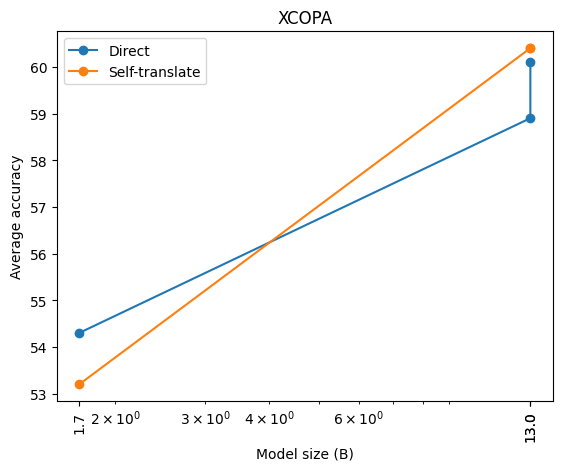

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,ar,bg,de,el,en,es,fr,...,ru,sw,th,tr,ur,vi,zh,avg,high,low
polylm-1.7b,polylm,1.7,Direct,33.3,34.9,43.9,33.5,48.4,41.3,42.7,...,43.4,33.7,35.8,35.1,33.8,40.7,34.3,37.4,41.1,34.8
polylm-1.7b,polylm,1.7,Self-translate,44.0,38.0,46.6,33.7,NaN,46.7,46.4,...,44.4,33.4,42.5,36.2,34.0,45.4,44.5,40.6,45.7,33.5
polylm-13b,polylm,13.0,Direct,33.6,36.3,50.2,33.8,54.6,50.0,52.1,...,49.0,34.4,44.6,44.5,33.5,46.7,35.9,41.4,47.4,34.3
polylm-multialpaca-13b,polylm,13.0,Direct,34.2,36.8,46.8,32.8,52.8,45.0,47.9,...,46.1,32.7,41.0,42.7,33.4,41.2,42.1,39.8,45.6,33.5
polylm-13b,polylm,13.0,Self-translate,49.3,42.2,52.8,35.0,NaN,52.9,52.7,...,50.3,34.8,49.2,49.6,33.9,50.7,50.7,45.6,51.9,34.4
polylm-multialpaca-13b,polylm,13.0,Self-translate,45.8,38.7,50.4,34.6,NaN,50.8,48.5,...,48.3,34.7,46.2,45.0,34.6,47.9,48.1,43.4,49.2,34.5


/tmp/ipykernel_1614158/135789990.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
 model &  size &        dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
polylm &   1.7 &         Direct & 33.3 & 34.9 & 43.9 & 33.5 & 48.4 & 41.3 & 42.7 & 36.9 & 43.4 & 33.7 & 35.8 & 35.1 & 33.8 & 40.7 & 34.3 & 37.4 &  41.1 & 34.8 \\
polylm &   1.7 & Self-translate & 44.0 & 38.0 & 46.6 & 33.7 &    \_ & 46.7 & 46.4 & 33.0 & 44.4 & 33.4 & 42.5 & 36.2 & 34.0 & 45.4 & 44.5 & 40.6 &  45.7 & 33.5 \\
polylm &  13.0 &         Direct & 33.6 & 36.3 & 50.2 & 33.8 & 54.6 & 50.0 & 52.1 & 34.9 & 49.0 & 34.4 & 44.6 & 44.5 & 33.5 & 46.7 & 35.9 & 41.4 &  47.4 & 34.3 \\
polylm &  13.0 &         Direct & 34.2 & 36.8 & 46.8 & 32.8 & 52.8 & 45.0 & 47.9 & 34.3 & 46.1 & 32.7 & 41.0 & 42.7 & 33.4 & 41.2 & 42.1 & 39.8 &  45.6 & 33.5 \\
polylm &  13.0 & Self-translate & 49.3 & 42.2 & 52.8 & 35.0 &    \_ & 52.9 & 52.7 & 34.4 & 50.3 & 34.8 & 49.2 & 49.6 & 33.9 & 50.7 &

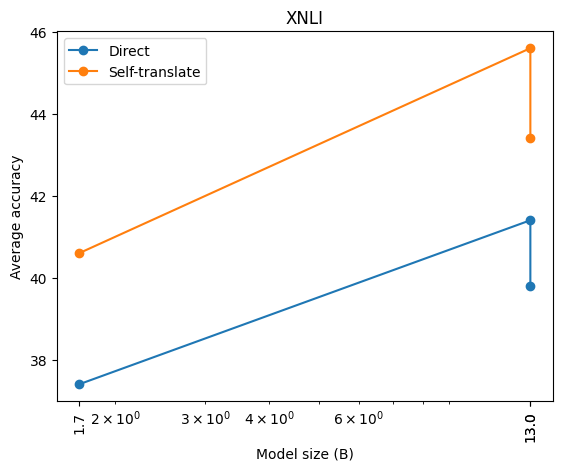

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,de,en,es,fr,ja,ko,zh,avg,high
polylm-1.7b,polylm,1.7,Direct,49.4,50.2,54.1,45.6,45.4,45.6,49.1,48.2,48.7
polylm-1.7b,polylm,1.7,Self-translate,50.9,NaN,50.6,49.9,48.3,47.4,49.2,49.4,49.8
polylm-13b,polylm,13.0,Direct,60.2,60.9,59.7,56.5,50.9,46.8,56.0,55.0,56.7
polylm-multialpaca-13b,polylm,13.0,Direct,61.1,62.3,60.4,56.8,51.4,53.6,53.2,56.1,56.6
polylm-13b,polylm,13.0,Self-translate,59.5,NaN,59.2,60.2,54.1,55.5,55.4,57.3,57.7
polylm-multialpaca-13b,polylm,13.0,Self-translate,62.4,NaN,61.8,61.2,54.5,55.8,56.1,58.6,59.2


\begin{tabular}{lrlrrrrrrrrr}
\toprule
 model &  size &        dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
polylm &   1.7 &         Direct & 49.4 & 50.2 & 54.1 & 45.6 & 45.4 & 45.6 & 49.1 & 48.2 &  48.7 \\
polylm &   1.7 & Self-translate & 50.9 &    \_ & 50.6 & 49.9 & 48.3 & 47.4 & 49.2 & 49.4 &  49.8 \\
polylm &  13.0 &         Direct & 60.2 & 60.9 & 59.7 & 56.5 & 50.9 & 46.8 & 56.0 & 55.0 &  56.7 \\
polylm &  13.0 &         Direct & 61.1 & 62.3 & 60.4 & 56.8 & 51.4 & 53.6 & 53.2 & 56.1 &  56.6 \\
polylm &  13.0 & Self-translate & 59.5 &    \_ & 59.2 & 60.2 & 54.1 & 55.5 & 55.4 & 57.3 &  57.7 \\
polylm &  13.0 & Self-translate & 62.4 &    \_ & 61.8 & 61.2 & 54.5 & 55.8 & 56.1 & 58.6 &  59.2 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/135789990.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


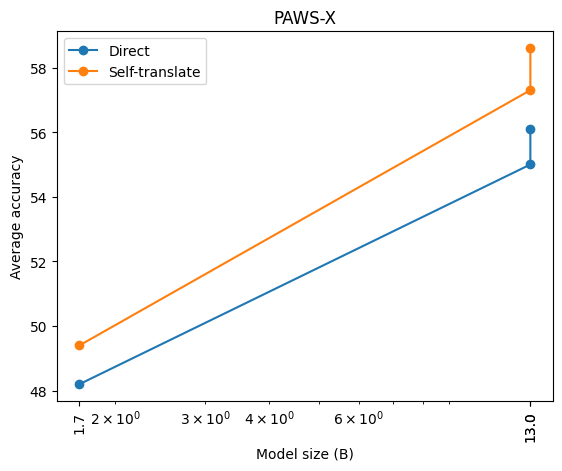

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,high,low
polylm-1.7b,polylm,1.7,Direct,0.0,2.0,0.8,2.4,1.6,0.0,1.2,2.4,0.0,3.6,1.2,1.4,1.4,0.8
polylm-1.7b,polylm,1.7,Self-translate,1.6,2.0,NaN,1.2,2.0,0.0,3.2,1.2,0.8,2.4,2.0,1.6,1.7,1.2
polylm-13b,polylm,13.0,Direct,0.0,6.4,8.8,5.6,7.6,3.2,7.2,2.4,0.0,5.6,6.4,4.4,6.1,0.8
polylm-multialpaca-13b,polylm,13.0,Direct,0.0,6.0,6.8,3.6,4.0,4.8,4.4,3.2,0.0,3.6,5.2,3.5,4.7,1.1
polylm-13b,polylm,13.0,Self-translate,3.2,6.4,NaN,8.0,6.4,5.2,8.4,2.4,0.4,6.4,6.0,5.3,6.7,2.0
polylm-multialpaca-13b,polylm,13.0,Self-translate,1.2,5.6,NaN,6.8,6.8,3.6,5.2,0.8,0.4,4.0,4.4,3.9,5.4,0.8


/tmp/ipykernel_1614158/135789990.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
 model &  size &        dataset &  bn &  de &  en &  es &  fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
polylm &   1.7 &         Direct & 0.0 & 2.0 & 0.8 & 2.4 & 1.6 & 0.0 & 1.2 & 2.4 & 0.0 & 3.6 & 1.2 &  1.4 &   1.4 &  0.8 \\
polylm &   1.7 & Self-translate & 1.6 & 2.0 &   \_ & 1.2 & 2.0 & 0.0 & 3.2 & 1.2 & 0.8 & 2.4 & 2.0 &  1.6 &   1.7 &  1.2 \\
polylm &  13.0 &         Direct & 0.0 & 6.4 & 8.8 & 5.6 & 7.6 & 3.2 & 7.2 & 2.4 & 0.0 & 5.6 & 6.4 &  4.4 &   6.1 &  0.8 \\
polylm &  13.0 &         Direct & 0.0 & 6.0 & 6.8 & 3.6 & 4.0 & 4.8 & 4.4 & 3.2 & 0.0 & 3.6 & 5.2 &  3.5 &   4.7 &  1.1 \\
polylm &  13.0 & Self-translate & 3.2 & 6.4 &   \_ & 8.0 & 6.4 & 5.2 & 8.4 & 2.4 & 0.4 & 6.4 & 6.0 &  5.3 &   6.7 &  2.0 \\
polylm &  13.0 & Self-translate & 1.2 & 5.6 &   \_ & 6.8 & 6.8 & 3.6 & 5.2 & 0.8 & 0.4 & 4.0 & 4.4 &  3.9 &   5.4 &  0.8 \\
\bottomrule
\end{tabular}



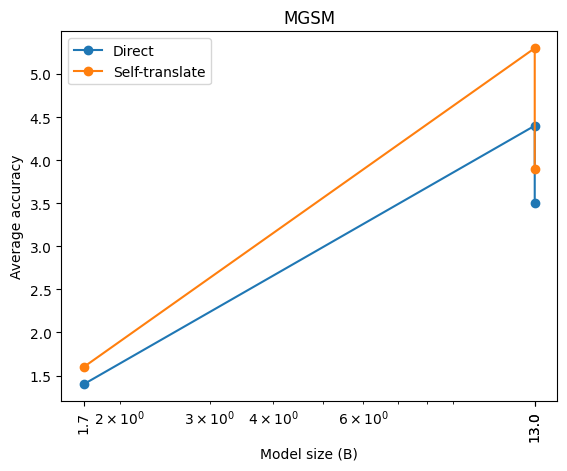

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)


,model,size,dataset,xstory_cloze,xcopa,xnli,pawsx,mgsm,avg
polylm-1.7b,polylm,1.7,Direct,51.8,54.3,37.4,48.2,1.4,38.6
polylm-1.7b,polylm,1.7,Self-translate,52.6,53.2,40.6,49.4,1.6,39.5
polylm-13b,polylm,13.0,Direct,56.3,58.9,41.4,55.0,4.4,43.2
polylm-multialpaca-13b,polylm,13.0,Direct,58.8,60.1,39.8,56.1,3.5,43.7
polylm-13b,polylm,13.0,Self-translate,57.4,60.4,45.6,57.3,5.3,45.2
polylm-multialpaca-13b,polylm,13.0,Self-translate,60.0,60.4,43.4,58.6,3.9,45.3


/tmp/ipykernel_1614158/135789990.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
 model &  size &        dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
polylm &   1.7 &         Direct &          51.8 &   54.3 &  37.4 &   48.2 &   1.4 & 38.6 \\
polylm &   1.7 & Self-translate &          52.6 &   53.2 &  40.6 &   49.4 &   1.6 & 39.5 \\
polylm &  13.0 &         Direct &          56.3 &   58.9 &  41.4 &   55.0 &   4.4 & 43.2 \\
polylm &  13.0 &         Direct &          58.8 &   60.1 &  39.8 &   56.1 &   3.5 & 43.7 \\
polylm &  13.0 & Self-translate &          57.4 &   60.4 &  45.6 &   57.3 &   5.3 & 45.2 \\
polylm &  13.0 & Self-translate &          60.0 &   60.4 &  43.4 &   58.6 &   3.9 & 45.3 \\
\bottomrule
\end{tabular}



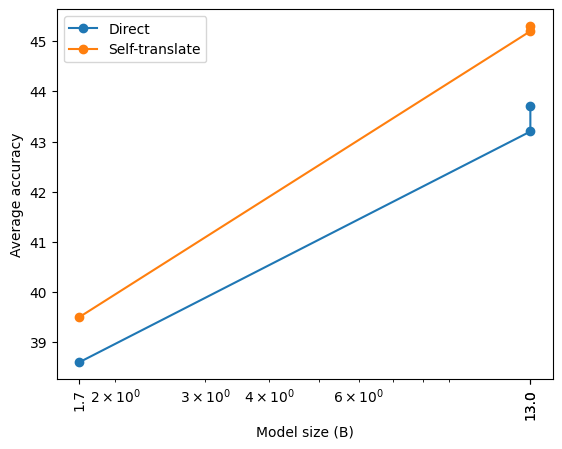

In [37]:
dfs_polylm = get_dataframes_model(all_results, datasets, "polylm")

for i, df in enumerate(dfs_polylm):
    display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "polylm", datasets_avg[i])

## Falcon

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,high,low
falcon-7b,falcon,7.0,Direct,47.9,78.0,69.4,50.0,48.6,55.7,48.3,53.7,48.5,52.3,64.1,53.9,62.4,49.5
falcon-40b,falcon,40.0,Direct,50.0,80.7,74.5,52.9,51.5,63.3,47.4,64.6,51.8,53.5,68.6,57.8,69.2,51.4


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
 model &  size & dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
falcon &   7.0 &  Direct & 47.9 & 78.0 & 69.4 & 50.0 & 48.6 & 55.7 & 48.3 & 53.7 & 48.5 & 52.3 & 64.1 & 53.9 &  62.4 & 49.5 \\
falcon &  40.0 &  Direct & 50.0 & 80.7 & 74.5 & 52.9 & 51.5 & 63.3 & 47.4 & 64.6 & 51.8 & 53.5 & 68.6 & 57.8 &  69.2 & 51.4 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/347619825.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


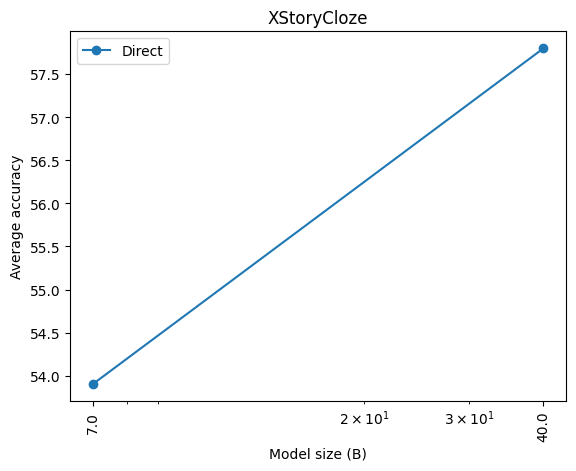

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,high,low
falcon-7b,falcon,7.0,Direct,49.6,50.0,55.0,73.6,50.0,51.8,56.6,54.6,55.0,50.2,69.4,56.0,69.4,51.6
falcon-40b,falcon,40.0,Direct,47.8,51.0,66.0,79.2,49.4,53.6,54.8,55.2,54.2,56.4,76.4,58.5,76.4,51.3


/tmp/ipykernel_1614158/347619825.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
 model &  size & dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
falcon &   7.0 &  Direct & 49.6 & 50.0 & 55.0 & 73.6 & 50.0 & 51.8 & 56.6 & 54.6 & 55.0 & 50.2 & 69.4 & 56.0 &  69.4 & 51.6 \\
falcon &  40.0 &  Direct & 47.8 & 51.0 & 66.0 & 79.2 & 49.4 & 53.6 & 54.8 & 55.2 & 54.2 & 56.4 & 76.4 & 58.5 &  76.4 & 51.3 \\
\bottomrule
\end{tabular}



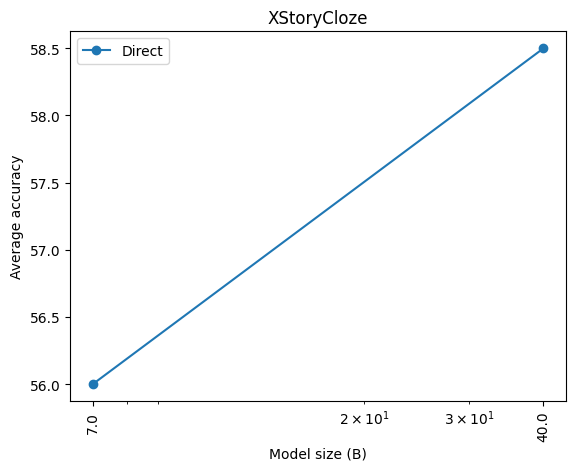

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,ar,bg,de,el,en,es,fr,...,ru,sw,th,tr,ur,vi,zh,avg,high,low
falcon-7b,falcon,7.0,Direct,33.4,34.0,46.9,35.2,53.4,48.9,49.7,...,40.7,33.6,35.7,34.8,33.4,36.6,35.3,38.1,44.3,33.8
falcon-40b,falcon,40.0,Direct,33.7,41.2,48.9,34.8,55.0,49.5,48.2,...,40.2,34.8,38.1,36.4,33.4,38.3,34.6,39.2,44.3,34.9


/tmp/ipykernel_1614158/347619825.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrrrrrr}
\toprule
 model &  size & dataset &   ar &   bg &   de &   el &   en &   es &   fr &   hi &   ru &   sw &   th &   tr &   ur &   vi &   zh &  avg &  high &  low \\
\midrule
falcon &   7.0 &  Direct & 33.4 & 34.0 & 46.9 & 35.2 & 53.4 & 48.9 & 49.7 & 34.5 & 40.7 & 33.6 & 35.7 & 34.8 & 33.4 & 36.6 & 35.3 & 38.1 &  44.3 & 33.8 \\
falcon &  40.0 &  Direct & 33.7 & 41.2 & 48.9 & 34.8 & 55.0 & 49.5 & 48.2 & 36.6 & 40.2 & 34.8 & 38.1 & 36.4 & 33.4 & 38.3 & 34.6 & 39.2 &  44.3 & 34.9 \\
\bottomrule
\end{tabular}



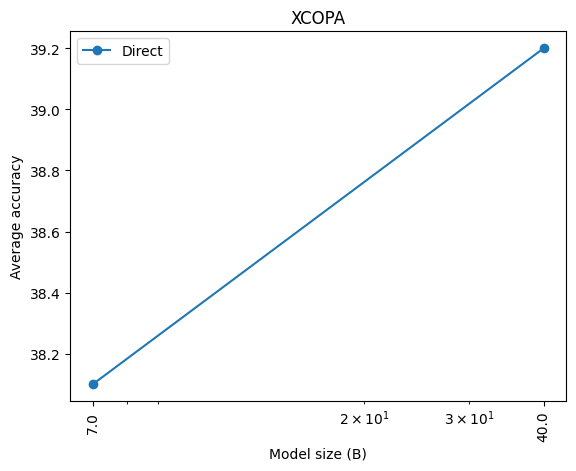

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,de,en,es,fr,ja,ko,zh,avg,high
falcon-7b,falcon,7.0,Direct,58.1,63.2,58.4,54.0,44.9,48.9,55.2,53.2,54.1
falcon-40b,falcon,40.0,Direct,63.6,64.2,63.3,56.2,49.3,50.1,60.4,57.2,58.6


\begin{tabular}{lrlrrrrrrrrr}
\toprule
 model &  size & dataset &   de &   en &   es &   fr &   ja &   ko &   zh &  avg &  high \\
\midrule
falcon &   7.0 &  Direct & 58.1 & 63.2 & 58.4 & 54.0 & 44.9 & 48.9 & 55.2 & 53.2 &  54.1 \\
falcon &  40.0 &  Direct & 63.6 & 64.2 & 63.3 & 56.2 & 49.3 & 50.1 & 60.4 & 57.2 &  58.6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1614158/347619825.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


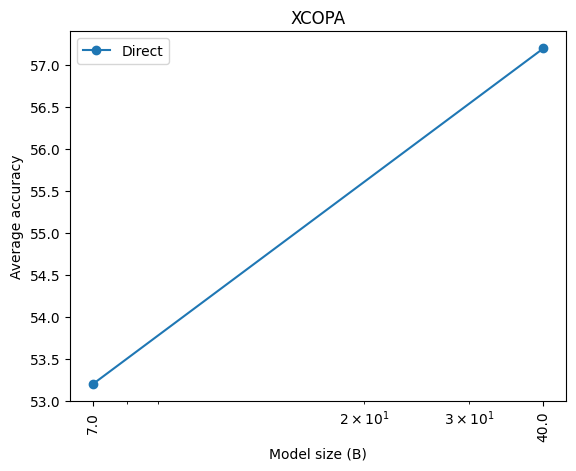

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,high,low
falcon-7b,falcon,7.0,Direct,0.0,2.8,8.8,7.2,7.6,0.0,0.0,2.0,0.0,0.0,3.6,2.3,3.5,0.7


/tmp/ipykernel_1614158/347619825.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
 model &  size & dataset &  bn &  de &  en &  es &  fr &  ja &  ru &  sw &  te &  th &  zh &  avg &  high &  low \\
\midrule
falcon &   7.0 &  Direct & 0.0 & 2.8 & 8.8 & 7.2 & 7.6 & 0.0 & 0.0 & 2.0 & 0.0 & 0.0 & 3.6 &  2.3 &   3.5 &  0.7 \\
\bottomrule
\end{tabular}



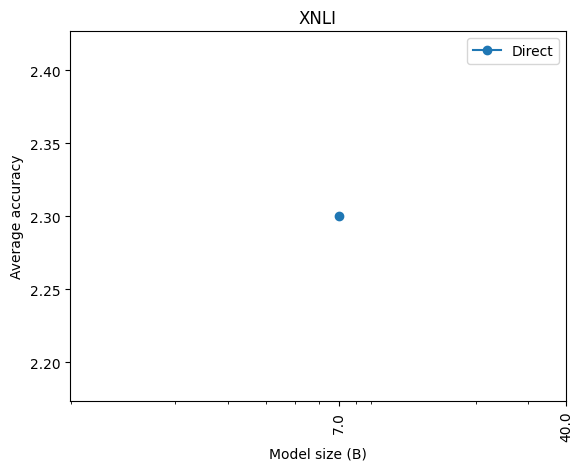

/tmp/ipykernel_1614158/623532130.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)


,model,size,dataset,xstory_cloze,xcopa,xnli,pawsx,mgsm,avg
falcon-7b,falcon,7.0,Direct,53.9,56.0,38.1,53.2,2.3,40.7
falcon-40b,NaN,NaN,NaN,57.8,58.5,39.2,57.2,NaN,53.2


/tmp/ipykernel_1614158/347619825.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrr}
\toprule
 model &  size & dataset &  xstory\_cloze &  xcopa &  xnli &  pawsx &  mgsm &  avg \\
\midrule
falcon &   7.0 &  Direct &          53.9 &   56.0 &  38.1 &   53.2 &   2.3 & 40.7 \\
     \_ &     \_ &       \_ &          57.8 &   58.5 &  39.2 &   57.2 &     \_ & 53.2 \\
\bottomrule
\end{tabular}



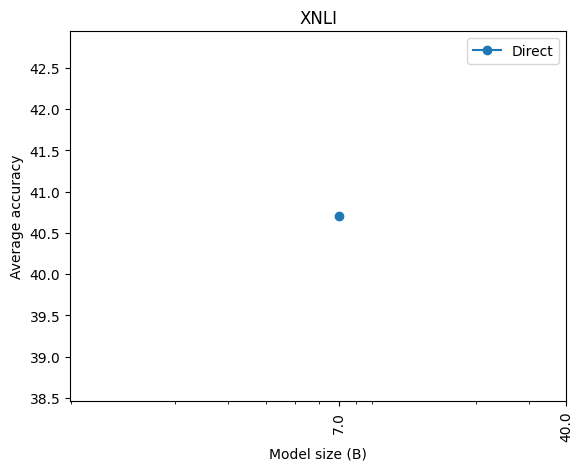

In [38]:
dfs_falcon = get_dataframes_model(all_results, datasets, "falcon")

for i, df in enumerate(dfs_falcon):
    display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "falcon", datasets_avg[i//2])

## XGen

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,high,low
xgen-7b-4k-base,xgen,7.0,Direct,48.9,73.6,63.9,51.0,51.8,48.9,48.0,59.7,50.4,54.4,54.3,53.1,59.3,51.1
xgen-7b-8k-base,xgen,7.0,Direct,48.6,74.8,62.7,51.3,51.7,51.8,48.0,59.0,50.0,52.9,56.8,53.3,59.5,50.8
xgen-7b-8k-inst,xgen,7.0,Direct,51.4,76.4,65.5,51.3,53.0,52.3,47.5,61.4,51.2,52.2,60.1,54.6,62.3,51.0


/tmp/ipykernel_1614158/3582926596.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size & dataset &   ar &   en &   es &   eu &   hi &   id &   my &   ru &   sw &   te &   zh &  avg &  high &  low \\
\midrule
 xgen &   7.0 &  Direct & 48.9 & 73.6 & 63.9 & 51.0 & 51.8 & 48.9 & 48.0 & 59.7 & 50.4 & 54.4 & 54.3 & 53.1 &  59.3 & 51.1 \\
 xgen &   7.0 &  Direct & 48.6 & 74.8 & 62.7 & 51.3 & 51.7 & 51.8 & 48.0 & 59.0 & 50.0 & 52.9 & 56.8 & 53.3 &  59.5 & 50.8 \\
 xgen &   7.0 &  Direct & 51.4 & 76.4 & 65.5 & 51.3 & 53.0 & 52.3 & 47.5 & 61.4 & 51.2 & 52.2 & 60.1 & 54.6 &  62.3 & 51.0 \\
\bottomrule
\end{tabular}



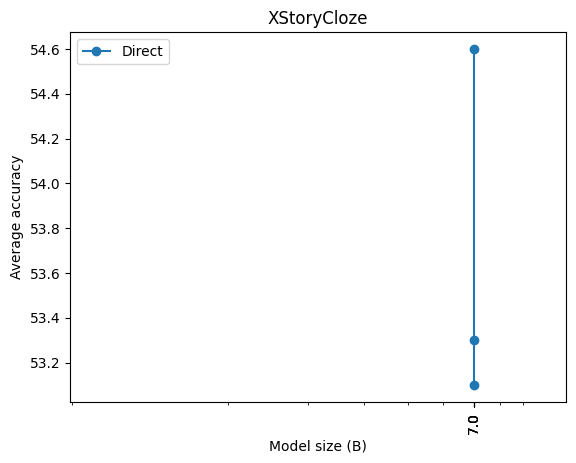

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")


,model,size,dataset,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,high,low
xgen-7b-4k-base,xgen,7.0,Direct,47.4,52.6,54.0,61.6,51.0,51.2,55.8,55.4,52.6,51.6,59.0,53.8,59.0,51.6
xgen-7b-8k-base,xgen,7.0,Direct,50.4,52.4,53.0,59.8,50.6,52.8,55.4,55.4,54.2,51.4,56.8,53.8,56.8,52.3
xgen-7b-8k-inst,xgen,7.0,Direct,49.0,49.4,54.4,61.4,49.6,52.4,54.2,55.2,52.6,53.0,58.2,53.6,58.2,50.9


/tmp/ipykernel_1614158/3582926596.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, na_rep="_"))


\begin{tabular}{lrlrrrrrrrrrrrrrr}
\toprule
model &  size & dataset &   et &   ht &   id &   it &   qu &   sw &   ta &   th &   tr &   vi &   zh &  avg &  high &  low \\
\midrule
 xgen &   7.0 &  Direct & 47.4 & 52.6 & 54.0 & 61.6 & 51.0 & 51.2 & 55.8 & 55.4 & 52.6 & 51.6 & 59.0 & 53.8 &  59.0 & 51.6 \\
 xgen &   7.0 &  Direct & 50.4 & 52.4 & 53.0 & 59.8 & 50.6 & 52.8 & 55.4 & 55.4 & 54.2 & 51.4 & 56.8 & 53.8 &  56.8 & 52.3 \\
 xgen &   7.0 &  Direct & 49.0 & 49.4 & 54.4 & 61.4 & 49.6 & 52.4 & 54.2 & 55.2 & 52.6 & 53.0 & 58.2 & 53.6 &  58.2 & 50.9 \\
\bottomrule
\end{tabular}



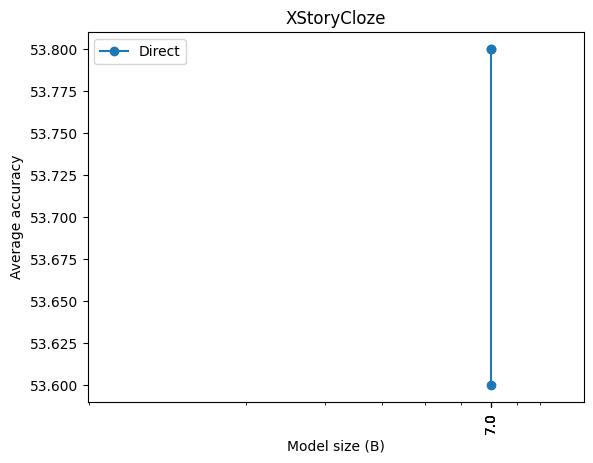

/tmp/ipykernel_1614158/623532130.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat["dataset"] = df_concat["dataset"].str.replace("Direct-mt_nllb-200-3.3B", "MT (NLLB)")
/tmp/ipykernel_1614158/623532130.py:52: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df_avg["model"] = df_concat["model"]


ValueError: cannot reindex on an axis with duplicate labels

In [39]:
dfs_xgen = get_dataframes_model(all_results, datasets, "xgen")

for i, df in enumerate(dfs_xgen):
    display(df)
    print(df.to_latex(index=False, na_rep="_"))
    plot_size_df_datasets(df, "xgen", datasets_avg[i//2])

## XGLM Combinations

In [ ]:
dfs_xglm_combinations = get_dataframes_model(all_results_bloom_xglm, datasets[:-1], "xglm")

for df in dfs_xglm_combinations:
    display(df)
    plot_size_df_datasets(df, "xglm")

## BLOOM Combinations

In [ ]:
dfs_bloom_combinations = get_dataframes_model(all_results_bloom_xglm, datasets[:-1], "bloom")

for df in dfs_bloom_combinations:
    display(df)
    plot_size_df_datasets(df, "bloom")